# Unsupervised Pipeline to reduce dimensions as well as identify clusters to be used as an additional feature

Dimensionality reduction could be especially useful for the better performing sparse feature sets identified in Step 2 (Feature Engineering Part2) as they have quite high dimensions, even for the dense features with  lower dimensions -as smaller number of dimensions could make any supervised learning using these dimensions less computationally costly. At the same time we do need to be cautious of any substantial loss of variance due to the dimensionality reduction. 

Clustering would enable us to understand if the structure in the data is truly binary (as per the training data labels) or are there any other structures indicating that the true structure in the data is different from binary, which could make subsequent label prediction difficult.

Steps include :
1. Import libraries
2. Load files
3. Extract components from pickle objects
4. PCA preprocessing
5. Initial visualization of structure
6. Dimensionality Reduction including Evaluation
7. Clustering including evaluation
8. Conclusion
9. Selecting selected objects as pickle
10. Dependencies


# 1.Import Libraries

In [ ]:
# Installing Libraries
!pip install umap-learn

# Need to install the following 3 libraries at each run, restart runtime, then start notebook again while 
# commenting out the following 3 lines -this will allow dask client to run
# !pip install dask-ml
# !pip install "dask[dataframe]"
# !pip install delayed


# Import libraries
import gzip
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid") # Setting the seaborn theme as 'darkgrid'
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.covariance import empirical_covariance
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,TruncatedSVD,SparsePCA,KernelPCA
from sklearn.manifold import TSNE,MDS
from sklearn.naive_bayes import BernoulliNB
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture

import scipy.stats as stats
from scipy.sparse.linalg import svds



import umap.umap_ as umap


from tqdm import tqdm
from zipfile import ZipFile
import os
import pickle


from dask.distributed import Client
import joblib
# import dask_ml.joblib
# from sklearn.externals.joblib import parallel_backend

RANDOM_SEED=7007

In [ ]:
from dask.distributed import Client, LocalCluster 
# cluster=LocalCluster
# cluster
# Supressing DASK memory warnings
import logging

# client = Client(processes=False)
client = Client(processes=False,silence_logs=logging.ERROR)

INTERPRETATION

We loaded a set of key libraries

The dask libraries require that the notebook be restarted after installing them and then importing other libraries while commenting out the import of the dask libraries.

# 2.Load Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Use location of combined pickle file containing combined feature set

pickle_in = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/pkl_dict.pickle","rb")
loaded_dict = pickle.load(pickle_in)
pickle_in.close()

print(loaded_dict.keys())

dict_keys(['y_train', 'y_dev', 'y_test', 'word_vector_X_train', 'tfidf_vector_X_train', 'combined_word_vector_X_train', 'combined_tfidf_vector_X_train', 'combined_w2v_X_train', 'pos_tag_count_X_train', 'word_pos_tag_count_X_train', 'w2v_X_train', 'word_vector_X_dev', 'tfidf_vector_X_dev', 'combined_word_vector_X_dev', 'combined_tfidf_vector_X_dev', 'combined_w2v_X_dev', 'pos_tag_count_X_dev', 'word_pos_tag_count_X_dev', 'w2v_X_dev', 'word_vector_X_test', 'tfidf_vector_X_test', 'combined_word_vector_X_test', 'combined_tfidf_vector_X_test', 'combined_w2v_X_test', 'pos_tag_count_X_test', 'word_pos_tag_count_X_test', 'w2v_X_test', 'New_Training_df', 'dev_df', 'test_df'])


# 3.Extract components from pickle

In [ ]:
# Variables extraction
y_train=loaded_dict['y_train']
y_dev=loaded_dict['y_dev']
y_test=loaded_dict['y_test']

word_vector_X_train=loaded_dict['word_vector_X_train']
tfidf_vector_X_train=loaded_dict['tfidf_vector_X_train']
combined_word_vector_X_train=loaded_dict['combined_word_vector_X_train']
combined_tfidf_vector_X_train=loaded_dict['combined_tfidf_vector_X_train']
combined_w2v_X_train=loaded_dict['combined_w2v_X_train']
pos_tag_count_X_train=loaded_dict['pos_tag_count_X_train']
word_pos_tag_count_X_train=loaded_dict['word_pos_tag_count_X_train']
w2v_X_train=loaded_dict['w2v_X_train']

word_vector_X_dev=loaded_dict['word_vector_X_dev']
tfidf_vector_X_dev=loaded_dict['tfidf_vector_X_dev']
combined_word_vector_X_dev=loaded_dict['combined_word_vector_X_dev']
combined_tfidf_vector_X_dev=loaded_dict['combined_tfidf_vector_X_dev']
combined_w2v_X_dev=loaded_dict['combined_w2v_X_dev']
pos_tag_count_X_dev=loaded_dict['pos_tag_count_X_dev']
word_pos_tag_count_X_dev=loaded_dict['word_pos_tag_count_X_dev']
w2v_X_dev=loaded_dict['w2v_X_dev']

word_vector_X_test=loaded_dict['word_vector_X_test']
tfidf_vector_X_test=loaded_dict['tfidf_vector_X_test']
combined_word_vector_X_test=loaded_dict['combined_word_vector_X_test']
combined_tfidf_vector_X_test=loaded_dict['combined_tfidf_vector_X_test']
combined_w2v_X_test=loaded_dict['combined_w2v_X_test']
pos_tag_count_X_test=loaded_dict['pos_tag_count_X_test']
word_pos_tag_count_X_test=loaded_dict['word_pos_tag_count_X_test']
w2v_X_test=loaded_dict['w2v_X_test']




train_df_new=loaded_dict['New_Training_df']
dev_df=loaded_dict['dev_df']
test_df_1=loaded_dict['test_df']

print(train_df_new.head())
print(dev_df.head())

                                            original_text  ...  Unnamed: 0
344738  The group is named after Archduke Franz Ferdin...  ...      344738
315995  In 2003 , Rolling Stone magazine listed The Wa...  ...      315995
98604   Manor Creek is a city in Jefferson County , Ke...  ...       98604
42370   Evil Genius is a novel written by Catherine Ji...  ...       42370
123565  Sully is a commune in the Calvados département...  ...      123565

[5 rows x 101 columns]
                                            original_text  ...  Unnamed: 0
126880                                   Stoic Categories  ...      126880
18583   Louisiana uses parishes instead of counties , ...  ...       18583
130157  A Thursday in May or June -LRB- 60 days after ...  ...      130157
296568  The Gaza Strip is a stretch of land along the ...  ...      296568
105847  Construction of London 's Crossrail project is...  ...      105847

[5 rows x 101 columns]


# 4.PCA Preprocessing, by column centering and scaling to unit variance

We will begin by exploring the best performing models from Step 2 notebook -1st Model (Bag of Word counts  bigram combined with word/character count + POS tag count) as well as the 2nd Model (Tfidf vectors bigram combined with word/character count + POS tag count) and check if there are any distinct structures. We will also check the uncombined sparse bigram arrays of bag of word count and tfidf weights.

We will also check for structures for the original dense features of word count, word+POS tag count and word2vec.

Let's begin, by checking the dimensions for these features.



In [ ]:
# Checking dimensions
print(combined_word_vector_X_train.shape)
print(combined_tfidf_vector_X_train.shape)
print(word_vector_X_train.shape)
print(tfidf_vector_X_train.shape)

print(word_pos_tag_count_X_train.shape)
print(w2v_X_train.shape)
print(combined_w2v_X_train.shape)

(300462, 110214)
(300462, 110214)
(300462, 110167)
(300462, 110167)
(300462, 47)
(300462, 100)
(300462, 147)


INTERPRETATION

We have features with varying dimensions from 47 or 100 (dense arrays) to even 110214 (sparse arrays).

We will apply PCA / SVD approaches to these feature sets and check the results, comparing them to each other.

Dimensionality reduction will enable further unsupervised & unsupervised pipelines to run faster due to efficient computation

We will begin by analyzing the 3 dense matrix features of pos_tag_count, word2vec and word2vec+pos_tag_count first, to be followed by the 2 sparse features.

Let's use Covariance matrix to check if we need to preprocess the data at all !

Let's start with the 3 dense features

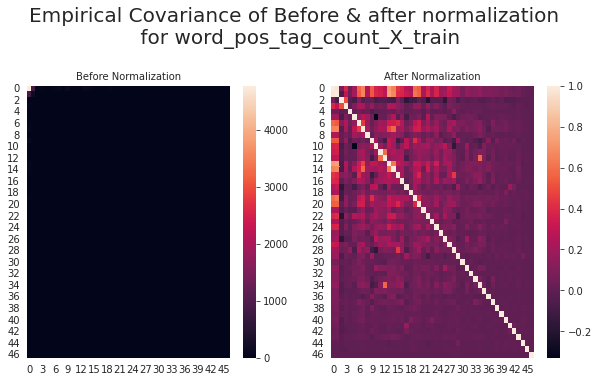

In [ ]:
# Check empirical covariance of word_pos_tag_count_X_train before & after normalization

# Normalizing the dense features 
scaler=StandardScaler()
scaler.fit(word_pos_tag_count_X_train)  

word_pos_tag_count_X_train_normalized=scaler.transform(word_pos_tag_count_X_train)  
word_pos_tag_count_X_dev_normalized=scaler.transform(word_pos_tag_count_X_dev)  
word_pos_tag_count_X_test_normalized=scaler.transform(word_pos_tag_count_X_test)  

# word_pos_tag_count_X_train_normalized=StandardScaler().transform(word_pos_tag_count_X_train)  
# word_pos_tag_count_X_dev_normalized=StandardScaler().transform(word_pos_tag_count_X_dev)  
# word_pos_tag_count_X_test_normalized=StandardScaler().transform(word_pos_tag_count_X_test)  


fig,((ax1, ax2))= plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Empirical Covariance of Before & after normalization \n for word_pos_tag_count_X_train',
             fontsize=20,x=0.5,y=1.1)

sns.heatmap(empirical_covariance(word_pos_tag_count_X_train),ax=ax1)
ax1.set_title('Before Normalization',fontsize=10)

sns.heatmap(empirical_covariance(word_pos_tag_count_X_train_normalized),ax=ax2)
ax2.set_title('After Normalization',fontsize=10)

plt.show()

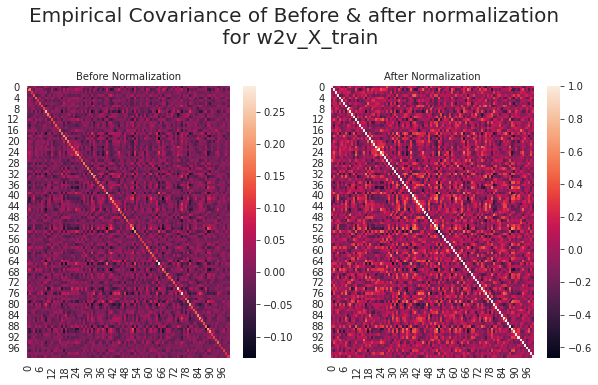

In [ ]:
# Check empirical covariance of w2v_X_train before & after normalization

# Normalizing the dense features 
scaler=StandardScaler()
scaler.fit(w2v_X_train)  

w2v_X_train_normalized=scaler.transform(w2v_X_train)  
w2v_X_dev_normalized=scaler.transform(w2v_X_dev)  
w2v_X_test_normalized=scaler.transform(w2v_X_test)  




# w2v_X_train_normalized=StandardScaler().fit_transform(w2v_X_train)  


fig,((ax1, ax2))= plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Empirical Covariance of Before & after normalization \n for w2v_X_train',
             fontsize=20,x=0.5,y=1.1)

sns.heatmap(empirical_covariance(w2v_X_train),ax=ax1)
ax1.set_title('Before Normalization',fontsize=10)

sns.heatmap(empirical_covariance(w2v_X_train_normalized),ax=ax2)
ax2.set_title('After Normalization',fontsize=10)

plt.show()

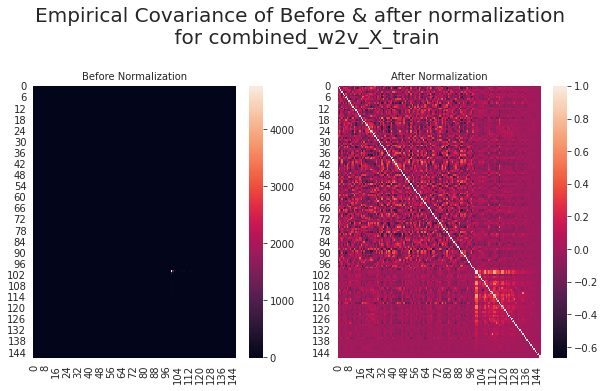

In [ ]:
# Check empirical covariance of combined_w2v_X_train before & after normalization

# Normalizing the dense features 
scaler=StandardScaler()
scaler.fit(combined_w2v_X_train)  

combined_w2v_X_train_normalized=scaler.transform(combined_w2v_X_train)  
combined_w2v_X_dev_normalized=scaler.transform(combined_w2v_X_dev)  
combined_w2v_X_test_normalized=scaler.transform(combined_w2v_X_test)  



# combined_w2v_X_train_normalized=StandardScaler().fit_transform(combined_w2v_X_train)  


fig,((ax1, ax2))= plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Empirical Covariance of Before & after normalization \n for combined_w2v_X_train',
             fontsize=20,x=0.5,y=1.1)

sns.heatmap(empirical_covariance(combined_w2v_X_train),ax=ax1)
ax1.set_title('Before Normalization',fontsize=10)

sns.heatmap(empirical_covariance(combined_w2v_X_train_normalized),ax=ax2)
ax2.set_title('After Normalization',fontsize=10)

plt.show()

INTERPRETATION

In the empirical covariance matrix of all 3 dense feature sets , post normalization the scale of the covariance shrinks to 0 to 1 scale, bringing all the features to the same scale.

This would prevent the situation of a high variance feature dominating the principal components.


What about covariance for the 2 sparse arrays ?

We will not create the covariance matrix for the sparse array inputs as they require operating on the entire matrix which would be computationally very expensive.

Also as we will be using Truncated SVD there is no need to center the data. 

# 5.Initial visualization of Structure

Basic PCA for the 3 dense features of word count+POS tag count, word2vec and word2vec+word count + POS tag count

Variance for word_pos_tag_count_X_train_normalized -->
Explained variation per principal component: [0.1435571 0.0476943]
Cumulative explained variation for 1st 2 principal components: 0.19125140446804442
Variance for w2v_X_train_normalized -->
Explained variation per principal component: [0.13908749 0.10480715]
Cumulative explained variation for 1st 2 principal components: 0.24389464414275405
Variance for combined_w2v_X_train_normalized -->
Explained variation per principal component: [0.09946176 0.07879081]
Cumulative explained variation for 1st 2 principal components: 0.17825257711487294


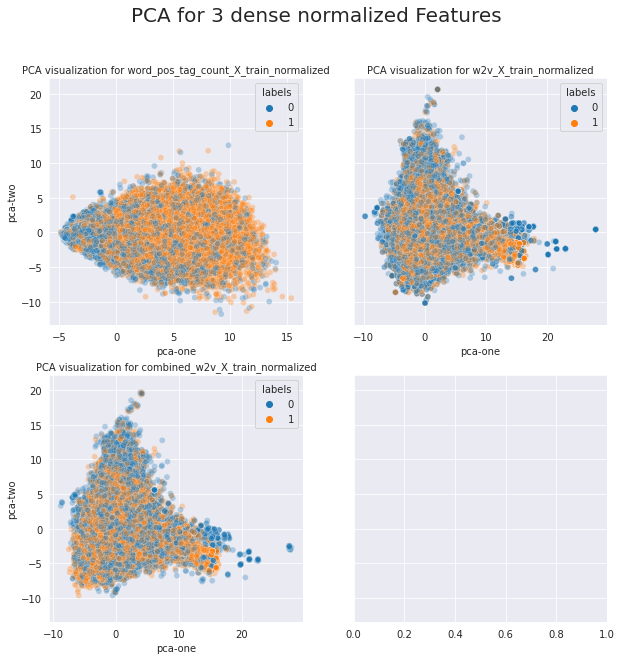

CPU times: user 52.1 s, sys: 14.2 s, total: 1min 6s
Wall time: 49.3 s


In [ ]:
%%time
fig, ((ax1, ax2),
      (ax3,ax4))= plt.subplots(2, 2,sharey=True,figsize=(10,10))
fig.suptitle('PCA for 3 dense normalized Features ',fontsize=20,x=0.5,y=.98)

ftr_lst=[word_pos_tag_count_X_train_normalized,w2v_X_train_normalized,
         combined_w2v_X_train_normalized]

ftr_lst1=['word_pos_tag_count_X_train_normalized','w2v_X_train_normalized',
         'combined_w2v_X_train_normalized']

ax_lst=[ax1,ax2,ax3]

for idx,val in enumerate(ax_lst):
  ax=ax_lst[idx]
  ftr=ftr_lst[idx]

  # Visualizing PCA on 2 dimensions 
  pca=PCA(2,random_state=RANDOM_SEED)

  pca1=pca.fit(ftr)
  print('Variance for '+ftr_lst1[idx]+' -->')
  print('Explained variation per principal component: {}'.format(pca1.explained_variance_ratio_))
  print('Cumulative explained variation for 1st 2 principal components: {}'.format(np.sum(pca1.explained_variance_ratio_)))

  pca11=pca1.transform(ftr)
  
  # Setting up the Visualization dataframe
  pca_df=pd.DataFrame()
  pca_df['pca-one'] = pca11[:,0]
  pca_df['pca-two'] = pca11[:,1]

  # Adding training labels
  pca_df['labels']=y_train

  # Visualizing the 1st 2 Principal components, also overlaying the labels
  ax.set_title('PCA visualization for '+ ftr_lst1[idx],fontsize=10)
  sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    data=pca_df,
    legend="full",
    alpha=0.3,ax=ax
)

plt.show()


INTERPRETATION

The data is not that well defined across the 3 normalized dense features, possibly as the 1st 2 PCs only account for a small portion of the Variance in each of the 3 dense features. Or is there some other issue affecting these overlapping structures without clear defined cluster ?

The question arises, how many PCs do we even need to account for say 80% of the variance in the data ?

How many Prinicipal components would explain say 80% of the variance in the data?

Shape of word_pos_tag_count_X_train_normalized --> (300462, 47)
Shape of w2v_X_train_normalized --> (300462, 100)
Shape of combined_w2v_X_train_normalized --> (300462, 147)


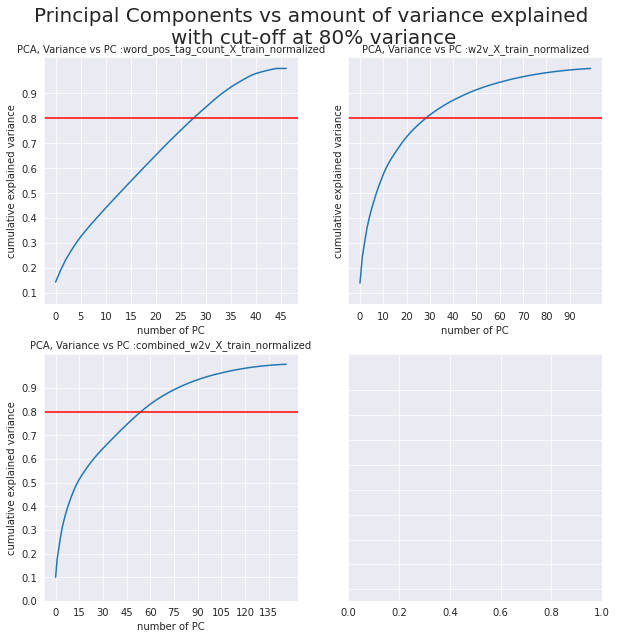

CPU times: user 28 s, sys: 1.39 s, total: 29.4 s
Wall time: 16.1 s


In [ ]:
%%time
# Running basic PCA on normalized word & pos tag count
 # How many PCs required to explain a certain variance
fig, ((ax1, ax2),
      (ax3,ax4))= plt.subplots(2, 2,sharey=True,figsize=(10,10))
fig.suptitle('Principal Components vs amount of variance explained \nwith cut-off at 80% variance',
             fontsize=20,x=0.5,y=0.95)


ftr_lst=[word_pos_tag_count_X_train_normalized,w2v_X_train_normalized,
         combined_w2v_X_train_normalized]

ftr_lst1=['word_pos_tag_count_X_train_normalized','w2v_X_train_normalized',
         'combined_w2v_X_train_normalized']

ax_lst=[ax1,ax2,ax3]

for idx,val in enumerate(ax_lst):
  ax=ax_lst[idx]
  ftr=ftr_lst[idx]

  print('Shape of '+ ftr_lst1[idx] +' -->',ftr.shape)
  pca = PCA(random_state=RANDOM_SEED).fit(ftr)
  ax.plot(np.cumsum(pca.explained_variance_ratio_))
  ax.set_xlabel('number of PC')
  ax.set_ylabel('cumulative explained variance')
  ax.set_yticks(np.arange(0, 1., 0.1))
  ax.set_xticks(np.arange(0, round(ftr.shape[1],-1) , round(ftr.shape[1],-1)/10))
  ax.set_title('PCA, Variance vs PC :' + ftr_lst1[idx] ,fontsize=10)
  # ax.grid()
  # Add a line at variance=0.8
  ax.axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show()




INTERPRETATION

The key take away is that a lot of Principal components is needed to explain at least 80% of the variance in the 3 dense features, when using basic PCA.
For word and POS Tag count features the Reduction rate is higher at 29/47= 57% and for the word2vec features it can be considered as 30/100 =30%. For the combined word, POS tag count and word2vec feature the compression ratio is around 56/147= 37%. 

Is there any other Dimension Reduction technique which is able to provide a better compression ratio ? This would allow us to use larger feature sets.

Let's check MDS for the smallest dimension feature set (word and POS Tag count features, 47 dimensions) and understand how much time it takes to reduce the dimensions for different sample options for various Dimension Reduction or Visualization techniques.







MDS on a limited sample of 1000 data instances for the smaller dimension feature set of word count + pos tag count

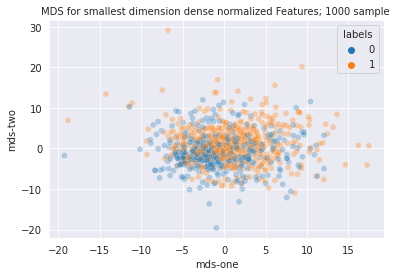

CPU times: user 43.6 s, sys: 17.7 s, total: 1min 1s
Wall time: 31.4 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):

  mds=MDS(2,random_state=RANDOM_SEED,n_jobs=-1)

  # Running MDS on a reduced sample
  word_pos_tag_count_X_train_normalized1=word_pos_tag_count_X_train_normalized[:1000,:]

  mds11=mds.fit_transform(word_pos_tag_count_X_train_normalized1)
    
  # Setting up the Visualization dataframe
  mds_df=pd.DataFrame()
  mds_df['mds-one'] = mds11[:,0]
  mds_df['mds-two'] = mds11[:,1]

  # Adding training labels
  mds_df['labels']=y_train[:1000]

    # Visualizing the 1st 2 MDS components, also overlaying the labels
  # ax.set_title('MDS for smallest dimension dense normalized Features ',fontsize=10)
  sns.scatterplot(
    x="mds-one", y="mds-two",
    hue="labels",
    data=mds_df,
    legend="full",
    alpha=0.3,
  )

  plt.title('MDS for smallest dimension dense normalized Features; 1000 sample ',fontsize=10)


  plt.show()

INTERPRETATION

Running a basic 2 dimension MDS on even the smallest dimension features (word and POS Tag count features, 47 dimensions) and a sample of only 1000 instances takes on average 30 secs.

Now as there are over 3,00,000 instances in the modified training set, and given the fact that MDS is an O(n^2) alorithm (Source :https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2375126/), the execution time would scale rapidly for the full sample.

Hence, we will not be using MDS to reduce dimensions for the various feature sets.



Now, let's check if cluster visualization techniques like tSNE or UMAP will show some distinct structures which basic PCA could not.

tSNE on smallest dimension features (word and POS Tag count features, 47 dimensions) and a sample of only 10000 instances

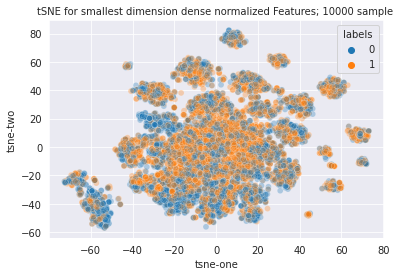

CPU times: user 3min 24s, sys: 1.65 s, total: 3min 26s
Wall time: 1min 53s


In [ ]:
%%time

with joblib.parallel_backend('dask'):

  # perpelxity=50 as the data set has 3,00,000 instances
  tsne=TSNE(perplexity=50,random_state=RANDOM_SEED,n_jobs=-1) 
  # Running UMAP on a reduced sample
  word_pos_tag_count_X_train_normalized1=word_pos_tag_count_X_train_normalized[:10000,:]

  tsne11=tsne.fit_transform(word_pos_tag_count_X_train_normalized1)
    
  # Setting up the Visualization dataframe
  tsne_df=pd.DataFrame()
  tsne_df['tsne-one'] = tsne11[:,0]
  tsne_df['tsne-two'] = tsne11[:,1]

  # Adding training labels
  tsne_df['labels']=y_train[:10000]

    # Visualizing the 1st 2 tSNE components, also overlaying the labels
  # ax.set_title('tSNE for smallest dimension dense normalized Features ',fontsize=10)
  sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="labels",
    data=tsne_df,
    legend="full",
    alpha=0.3,
  )

  plt.title('tSNE for smallest dimension dense normalized Features; 10000 sample ',fontsize=10)



  plt.show()

INTERPRETATION

Running a basic 2-dimension tSNE (preplexity=50 due to larger dataset size) on even the smallest dimension features (word and POS Tag count features, 47 dimensions) and a sample of only 10000 instances takes on average 2 mins.

Now as there are over 3,00,000 instances in the full sample of the training set, , the execution time would scale rapidly for the full sample.

Hence, we will not proceed with tSNE due to computational challenge.

A key point to note is large central overlapped data points belonging to different labels -will we continue to see this pattern even when using UMAP ?

UMAP on smallest dimension features (word and POS Tag count features, 47 dimensions) and a sequence of sample of only 100000 instances and full sample.

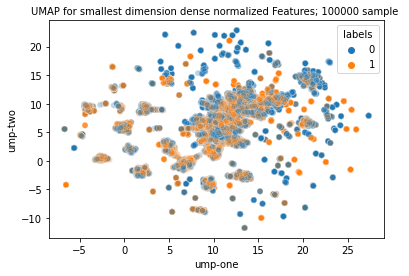

CPU times: user 4min 6s, sys: 11.8 s, total: 4min 18s
Wall time: 3min 29s


In [ ]:
%%time

ump=umap.UMAP(random_state=RANDOM_SEED) # Default settings

# Running UMAP on a reduced sample
word_pos_tag_count_X_train_normalized1=word_pos_tag_count_X_train_normalized[:100000,:]

ump11=ump.fit_transform(word_pos_tag_count_X_train_normalized1)
  
# Setting up the Visualization dataframe
ump_df=pd.DataFrame()
ump_df['ump-one'] = ump11[:,0]
ump_df['ump-two'] = ump11[:,1]

# Adding training labels
ump_df['labels']=y_train[:100000]

  # Visualizing the 1st 2 UMAP components, also overlaying the labels
ax.set_title('UMAP for smallest dimension dense normalized Features; 1,00,000 sample ',fontsize=10)
sns.scatterplot(
  x="ump-one", y="ump-two",
  hue="labels",
  data=ump_df,
  legend="full",
  alpha=0.3,
)

plt.title('UMAP for smallest dimension dense normalized Features; 100000 sample ',fontsize=10)



plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


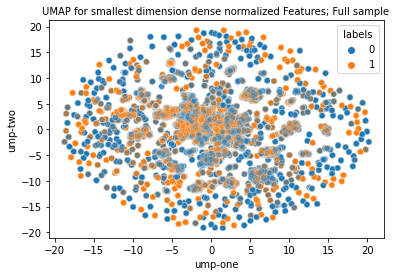

CPU times: user 52min, sys: 4min 36s, total: 56min 36s
Wall time: 34min 24s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(random_state=RANDOM_SEED) # Default

  # Running UMAP on a reduced sample
  word_pos_tag_count_X_train_normalized1=word_pos_tag_count_X_train_normalized[:,:]

  ump11=ump.fit_transform(word_pos_tag_count_X_train_normalized1)
    
  # Setting up the Visualization dataframe
  ump_df=pd.DataFrame()
  ump_df['ump-one'] = ump11[:,0]
  ump_df['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df['labels']=y_train[:]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  # ax.set_title('UMAP for smallest dimension dense normalized Features; 1,00,000 sample ',fontsize=10)
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; Full sample ',fontsize=10)

  plt.show()



INTERPRETATION

While UMAP ran on full sample, but it did take 30 mins and also there is no useful structure as such -it's just a big blob. But atleast it is working !

We would have to tweak the UMAP parameters to derive some useful structure and we will experiment using the 100,000 sample data set. Also possibly using the reduced dimensions (which we will derive later) could make the computation easier.



Let's visualize the 2 sparse features of bag of word count + word, POS tag count and tfidf weights + word, POS tag count.

Visualizing the combined word count feature

Explained variation per principal component: [9.84235757e-01 5.05815591e-03 2.65546880e-03 1.41209139e-03
 6.01758554e-04]
Cumulative explained variation for 5 principal components: 0.9939632315520734
svd_df.shape (300462, 6)


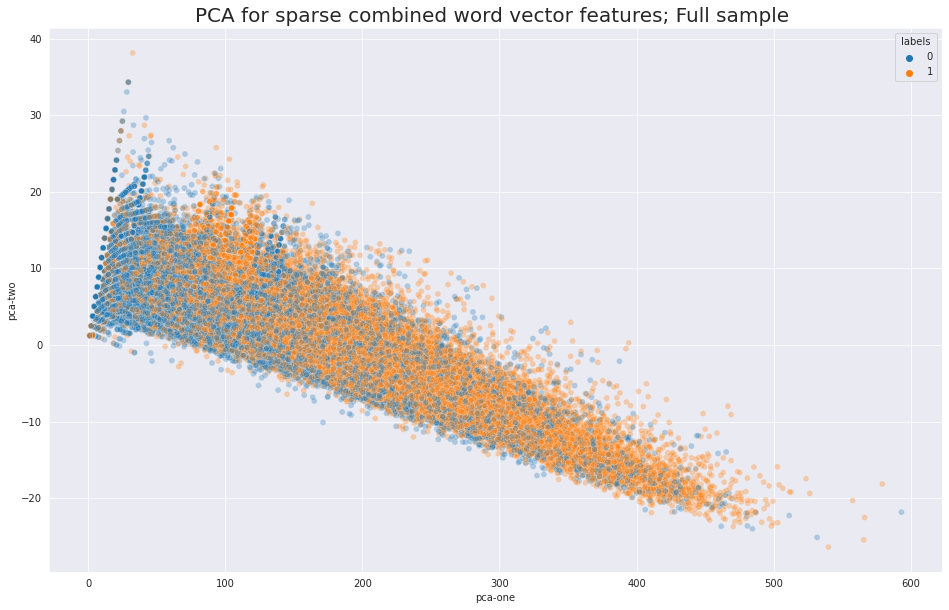

CPU times: user 18 s, sys: 3.97 s, total: 22 s
Wall time: 17.5 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
    # # running a truncated svd as that can handle sparse input but without col centering -which is not required that much for sparse input 
  # # 5 dimensions chosen
  svd = TruncatedSVD(n_components=5,random_state=RANDOM_SEED) 
  svd_result=svd.fit_transform(combined_word_vector_X_train)

  # Setting up the Visualization dataframe
  svd_df=pd.DataFrame()
  svd_df['pca-one'] = svd_result[:,0]
  svd_df['pca-two'] = svd_result[:,1]
  svd_df['pca-three'] = svd_result[:,2]
  svd_df['pca-four'] = svd_result[:,3]
  svd_df['pca-five'] = svd_result[:,4]

  # Adding training labels
  svd_df['labels']=y_train

  print('Explained variation per principal component: {}'.format(svd.explained_variance_ratio_))
  print('Cumulative explained variation for 5 principal components: {}'.format(np.sum(svd.explained_variance_ratio_)))
  print('svd_df.shape',svd_df.shape)

  # Visualizing the 1st 2 Principal components, also overlaying the labels
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="labels",
      #palette=sns.color_palette("hls", 10),
      data=svd_df,
      legend="full",
      alpha=0.3
  )

  plt.title('PCA for sparse combined word vector features; Full sample ',fontsize=20)

  plt.show()


INTERPRETATION

The structure is not that meaningful, possibly as the 1st SVD component itself is accounting for 99% of the variance.

Let's see the structure for the combined tfidf feature 

Explained variation per principal component: [9.87048700e-01 5.07093264e-03 2.66008621e-03 1.41522332e-03
 6.01744352e-04]
Cumulative explained variation for 5 principal components: 0.9967966869019157
svd_df.shape (300462, 6)


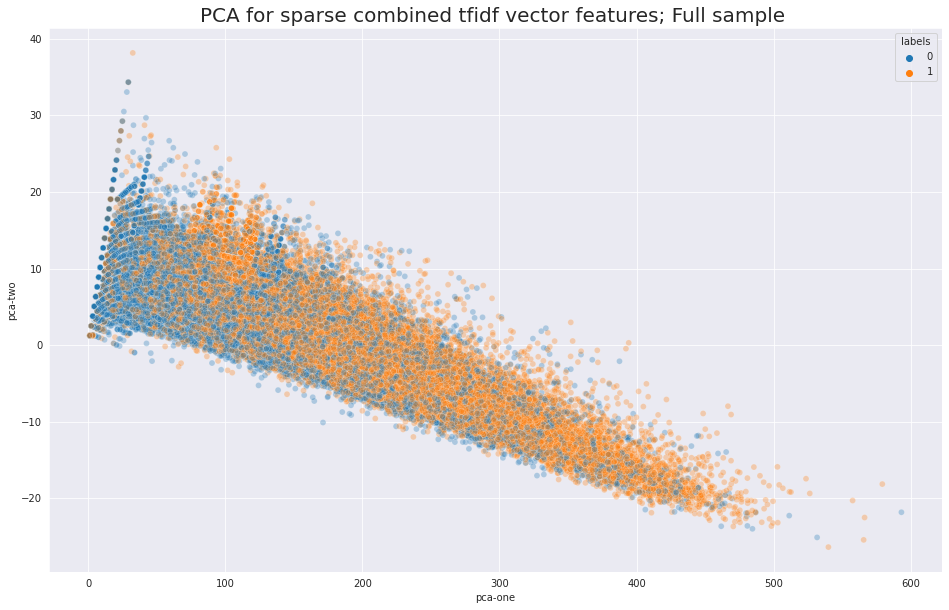

CPU times: user 18.2 s, sys: 3.85 s, total: 22.1 s
Wall time: 17.6 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
  # # Running basic PCA for tfidf vector features
  # # running a truncated svd as that can handle sparse input but without col centering -which is not required that much for sparse input 
  # # 5 dimensions chosen
  svd = TruncatedSVD(n_components=5,random_state=RANDOM_SEED) 
  svd_result=svd.fit_transform(combined_tfidf_vector_X_train)

  # Setting up the Visualization dataframe
  svd_df=pd.DataFrame()
  svd_df['pca-one'] = svd_result[:,0]
  svd_df['pca-two'] = svd_result[:,1]
  svd_df['pca-three'] = svd_result[:,2]
  svd_df['pca-four'] = svd_result[:,3]
  svd_df['pca-five'] = svd_result[:,4]

  # Adding training labels
  svd_df['labels']=y_train

  print('Explained variation per principal component: {}'.format(svd.explained_variance_ratio_))
  print('Cumulative explained variation for 5 principal components: {}'.format(np.sum(svd.explained_variance_ratio_)))
  print('svd_df.shape',svd_df.shape)

  # Visualizing the 1st 2 Principal components, also overlaying the labels
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="labels",
      #palette=sns.color_palette("hls", 10),
      data=svd_df,
      legend="full",
      alpha=0.3
  )

  plt.title('PCA for sparse combined tfidf vector features; Full sample ',fontsize=20)

  plt.show()


INTERPRETATION

Even for the combined tfidf vector we see a similar lack of a coherent structure as it also has the 1st SVD component explaining 99% of the variance.

What if we use the original sparse arrays, without combining the word, POS tag count dense arrays.

Will that make any difference in the structure as well as the variance split across the SVD components ?

Cumulative explained variation for 100 SVD components: 0.14336803723828412
svd_df.shape (300462, 6)


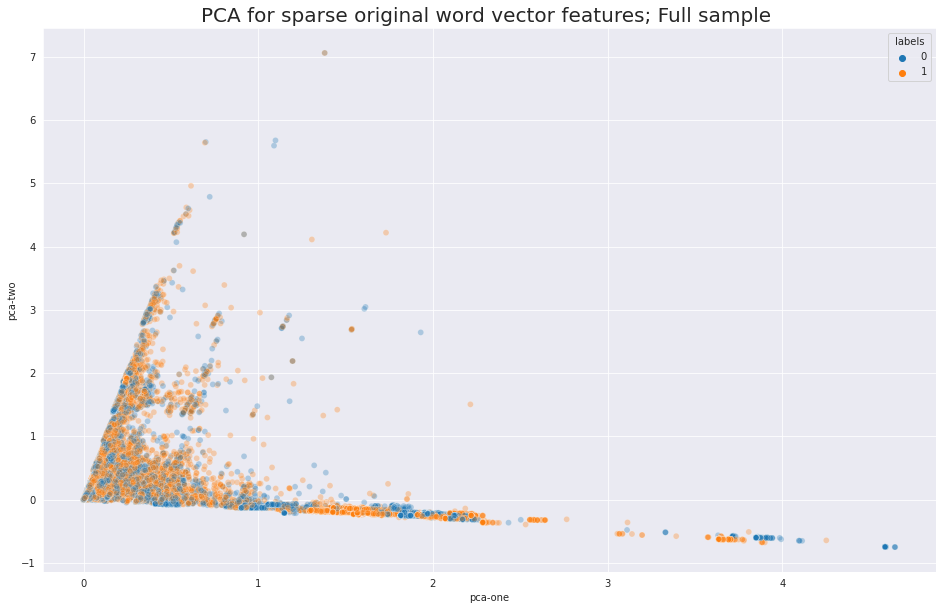

CPU times: user 1min 7s, sys: 9.39 s, total: 1min 16s
Wall time: 57.1 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
  # # Running basic PCA for word vector features
  # # running a truncated svd as that can handle sparse input but without col centering -which is not required that much for sparse input 
  # # 100 dimensions chosen
  svd = TruncatedSVD(n_components=100,random_state=RANDOM_SEED) 
  svd_result=svd.fit_transform(word_vector_X_train)

  # Setting up the Visualization dataframe
  svd_df=pd.DataFrame()
  svd_df['pca-one'] = svd_result[:,0]
  svd_df['pca-two'] = svd_result[:,1]
  svd_df['pca-three'] = svd_result[:,2]
  svd_df['pca-four'] = svd_result[:,3]
  svd_df['pca-five'] = svd_result[:,4]

  # Adding training labels
  svd_df['labels']=y_train

  # print('Explained variation per principal component: {}'.format(svd.explained_variance_ratio_))
  print('Cumulative explained variation for 100 SVD components: {}'.format(np.sum(svd.explained_variance_ratio_)))
  print('svd_df.shape',svd_df.shape)

  # Visualizing the 1st 2 Principal components, also overlaying the labels
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="labels",
      #palette=sns.color_palette("hls", 10),
      data=svd_df,
      legend="full",
      alpha=0.3
  )

  plt.title('PCA for sparse original word vector features; Full sample ',fontsize=20)

  plt.show()


INTERPRETATION

This seems different from the visualization observed in the combined dense+ sparse word vector features.

Also as the 1st 100 features explain a lower amount of variance!

Let's replicate this approach for the original +sparse tfidf vector features.

Cumulative explained variation for 1st 100 SVD components: 0.07067782756430524
svd_df.shape (300462, 6)


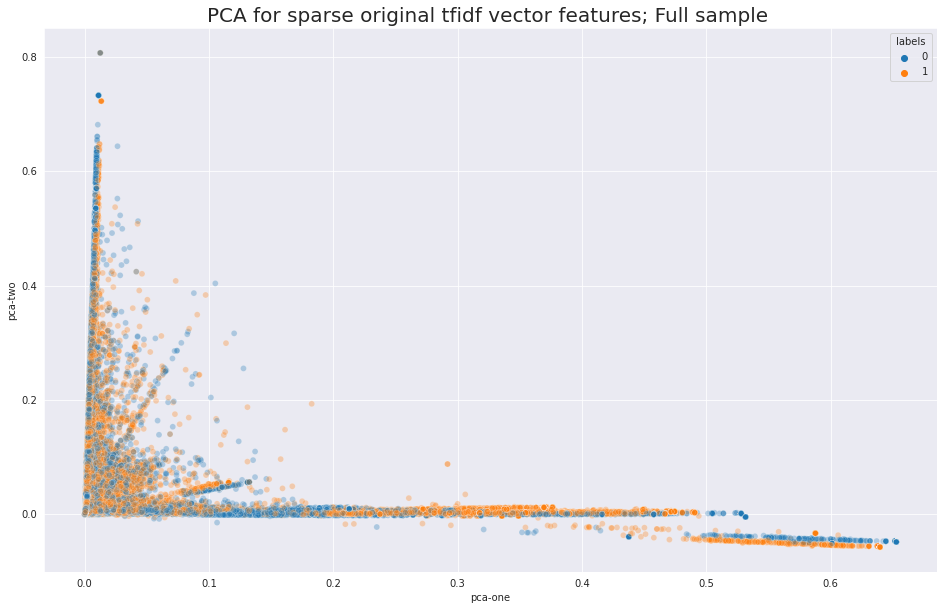

CPU times: user 1min 2s, sys: 7.89 s, total: 1min 10s
Wall time: 52 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
  # # Running basic PCA for word vector features
  # # running a truncated svd as that can handle sparse input but without col centering -which is not required that much for sparse input 
  # # 100 dimensions chosen
  svd = TruncatedSVD(n_components=100,random_state=RANDOM_SEED) 
  svd_result=svd.fit_transform(tfidf_vector_X_train)

  # Setting up the Visualization dataframe
  svd_df=pd.DataFrame()
  svd_df['pca-one'] = svd_result[:,0]
  svd_df['pca-two'] = svd_result[:,1]
  svd_df['pca-three'] = svd_result[:,2]
  svd_df['pca-four'] = svd_result[:,3]
  svd_df['pca-five'] = svd_result[:,4]

  # Adding training labels
  svd_df['labels']=y_train

  # print('Explained variation per principal component: {}'.format(svd.explained_variance_ratio_))
  print('Cumulative explained variation for 1st 100 SVD components: {}'.format(np.sum(svd.explained_variance_ratio_)))
  print('svd_df.shape',svd_df.shape)

  # Visualizing the 1st 2 Principal components, also overlaying the labels
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="labels",
      #palette=sns.color_palette("hls", 10),
      data=svd_df,
      legend="full",
      alpha=0.3
  )

  plt.title('PCA for sparse original tfidf vector features; Full sample ',fontsize=20)

  plt.show()


INTERPRETATION

This seems different from the visualization observed in the combined dense+ sparse tfidf vector features

The good thing is that the 1st SVD component does not take up 99% of the variance. The variance is more spread out across the potentially more than 100,000 SVD components (as the data has >100,000 dimensions). We only computed 100 components.

Hence, let's use singular values to identify the most important SVD components and avoid focusing on the less important SVD components which would be present in a 'long tail'.


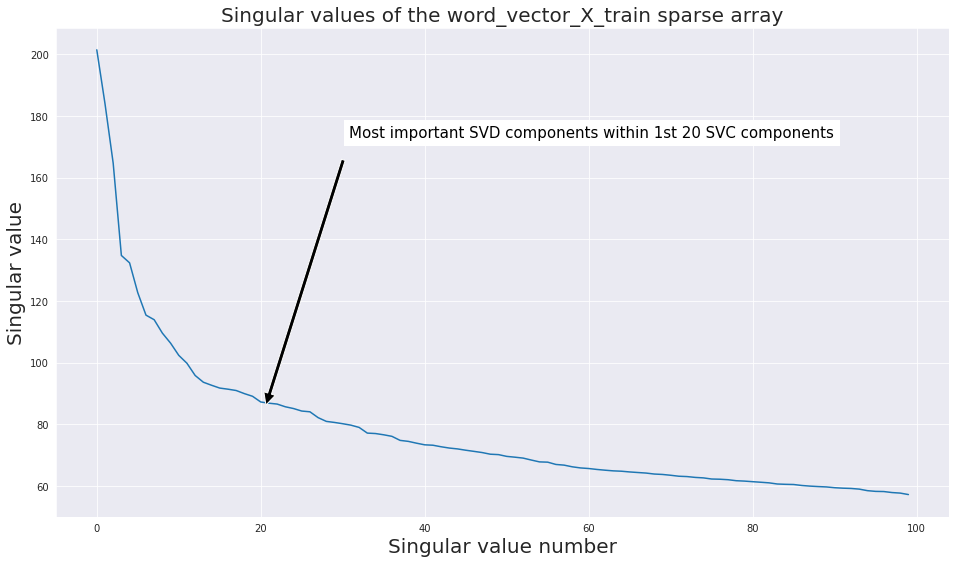

CPU times: user 53.1 s, sys: 4.61 s, total: 57.7 s
Wall time: 42.1 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):

  # Running basic PCA on normalized word & pos tag count
  # How many PCs required to explain a certain variance
  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()
  n=100
  svd = TruncatedSVD(n_components=n,random_state=RANDOM_SEED).fit(word_vector_X_train)
  plt.plot(svd.singular_values_)
  plt.xlabel("Singular value number",fontsize=20)
  plt.ylabel("Singular value",fontsize=20)
  plt.title('Singular values of the word_vector_X_train sparse array',fontsize=20)
  ax.annotate('Most important SVD components within 1st 20 SVC components',
                    color="black",fontsize=15, #fontweight='bold',
                     xy=(0.23, 0.2),  xycoords='axes fraction',
                    xytext=(.6, 0.8), textcoords='axes fraction',
                    arrowprops=dict(facecolor='k', shrink=0.05),
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=2)
                    )
  plt.show()

  



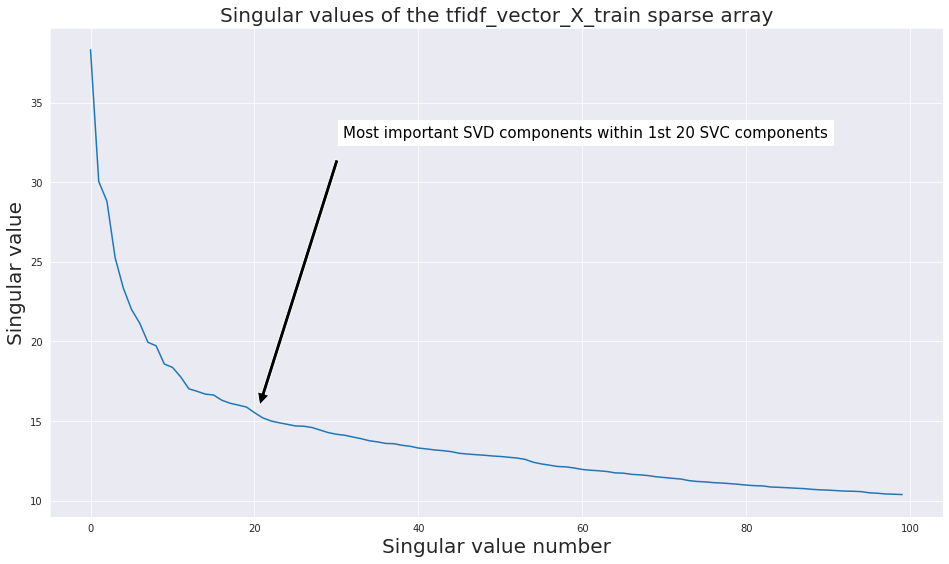

CPU times: user 51.5 s, sys: 4.79 s, total: 56.3 s
Wall time: 40.6 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):

  # Running basic PCA on normalized word & pos tag count
  # How many PCs required to explain a certain variance
  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()
  n=100
  svd = TruncatedSVD(n_components=n,random_state=RANDOM_SEED).fit(tfidf_vector_X_train)
  plt.plot(svd.singular_values_)
  plt.xlabel("Singular value number",fontsize=20)
  plt.ylabel("Singular value",fontsize=20)
  plt.title('Singular values of the tfidf_vector_X_train sparse array',fontsize=20)
  
  ax.annotate('Most important SVD components within 1st 20 SVC components',
                    color="black",fontsize=15, #fontweight='bold',
                     xy=(0.23, 0.2),  xycoords='axes fraction',
                    xytext=(.6, 0.8), textcoords='axes fraction',
                    arrowprops=dict(facecolor='k', shrink=0.05),
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=2)
                    )
  
  plt.show()

  



INTERPRETATION

We find that for word vector, the most important SVD components are within the 1st 20 components -lets truncate to 40 components to be safe.

Similarly for the tfidf vector, the most important SVD components are also within the 1st 20 components -lets truncate to 40 components to be safe.

# 6.1.Dimensionality Reduction

Implementing PCA on the 1st dense feature -->
word_pos_tag_count_X_train_normalized

We will choose the number of components as the 1st 29 /47 components which explain 80% of the variance

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
  # Setting up key parameters
  ftr=word_pos_tag_count_X_train_normalized
  pc_components=29

  # Creating the reduced dimensions
  pca=PCA(n_components=pc_components,random_state=RANDOM_SEED)

  pca1=pca.fit(ftr)
  # print('Variance for word_pos_tag_count_X_train_normalized -->')
  # print('Explained variation per principal component: {}'.format(pca1.explained_variance_ratio_))
  print('Cumulative explained variation for {} principal components: {}'.format(pc_components,np.sum(pca1.explained_variance_ratio_)))

  pca11=pca1.transform(ftr)

  print(pca11.shape)

  # # Setting up the Reduced dim dataframe
  pca_df1=pd.DataFrame()

  for c in range(pca11.shape[1]):
    # print (c)

    pca_df1['pca'+str(c)]=pca11[:,c]
  # pca_df1['pca-one'] = pca11[:,0]
  # pca_df1['pca-two'] = pca11[:,1]

  # # Adding training labels
  # pca_df1['labels']=y_train

  # print(pca_df1.shape)
  print(pca_df1.head())

  # Also saving the numpy array
  word_pos_tag_count_X_train_reduced=pca11
  word_pos_tag_count_X_dev_reduced=pca1.transform(word_pos_tag_count_X_dev_normalized)
  word_pos_tag_count_X_test_reduced=pca1.transform(word_pos_tag_count_X_test_normalized)

  # print(word_pos_tag_count_X_train_reduced)

Cumulative explained variation for 29 principal components: 0.8094238716594955
(300462, 29)
       pca0      pca1      pca2  ...     pca26     pca27     pca28
0 -2.531009  0.069469  0.193255  ... -0.104248  0.087420 -0.327856
1 -0.913687  3.128328 -1.711236  ... -0.357862  0.495948 -0.300183
2 -2.256440  1.053014 -0.031030  ... -0.278290 -0.274270  0.005164
3 -0.686502  0.677960  0.290886  ... -0.287202  0.214164 -0.365780
4 -1.372550  0.018304  1.274296  ...  0.396234 -0.210572 -0.083751

[5 rows x 29 columns]
CPU times: user 7.3 s, sys: 2.16 s, total: 9.46 s
Wall time: 5.63 s


Implementing PCA on the 2nd dense feature --> w2v_X_train_normalized

We will choose the number of components as the 1st 30 /100 components which explain 80% of the variance

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
  # Setting up key parameters
  ftr=w2v_X_train_normalized
  pc_components=30

  # Creating the reduced dimensions
  pca=PCA(n_components=pc_components,random_state=RANDOM_SEED)

  pca1=pca.fit(ftr)
  # print('Variance for w2v_X_train_normalized -->')
  # print('Explained variation per principal component: {}'.format(pca1.explained_variance_ratio_))
  print('Cumulative explained variation for {} principal components: {}'.format(pc_components,np.sum(pca1.explained_variance_ratio_)))

  pca11=pca1.transform(ftr)

  print(pca11.shape)

  # # Setting up the Reduced dim dataframe
  pca_df2=pd.DataFrame()

  for c in range(pca11.shape[1]):
    # print (c)

    pca_df2['pca'+str(c)]=pca11[:,c]
  # pca_df1['pca-one'] = pca11[:,0]
  # pca_df1['pca-two'] = pca11[:,1]

  # # Adding training labels
  # pca_df1['labels']=y_train

  # print(pca_df1.shape)
  print(pca_df2.head())

  # Also saving the numpy array
  w2v_X_train_reduced=pca11
  w2v_X_dev_reduced=pca1.transform(w2v_X_dev_normalized)
  w2v_X_test_reduced=pca1.transform(w2v_X_test_normalized)
  # print(w2v_X_train_reduced)


Cumulative explained variation for 30 principal components: 0.8058435293888547
(300462, 30)
        pca0      pca1      pca2  ...     pca27     pca28     pca29
0   0.618705  1.193027 -2.363538  ... -0.124164  0.414921 -0.813885
1  -3.366356  0.539858  1.443080  ...  1.359131  0.150795  0.856540
2   6.687591  0.599799 -4.345191  ...  0.173049  0.183943 -0.416362
3  -1.660962  2.027764  0.252738  ...  1.038263  0.330386 -0.553393
4  15.514495 -4.574200  5.055378  ... -0.267751 -0.324891 -1.151952

[5 rows x 30 columns]
CPU times: user 9.13 s, sys: 2.77 s, total: 11.9 s
Wall time: 7.12 s


Implementing PCA on the 3rd dense feature --> combined_w2v_X_train_normalized

We will choose the number of components as the 1st 56 /147 components which explain 80% of the variance

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  
  # Setting up key parameters
  ftr=combined_w2v_X_train_normalized
  pc_components=56

  # Creating the reduced dimensions
  pca=PCA(n_components=pc_components,random_state=RANDOM_SEED)

  pca1=pca.fit(ftr)
  # print('Variance for combined_w2v_X_train_normalized -->')
  # print('Explained variation per principal component: {}'.format(pca1.explained_variance_ratio_))
  print('Cumulative explained variation for {} principal components: {}'.format(pc_components,np.sum(pca1.explained_variance_ratio_)))

  pca11=pca1.transform(ftr)

  print(pca11.shape)

  # # Setting up the Reduced dim dataframe
  pca_df3=pd.DataFrame()

  for c in range(pca11.shape[1]):
    # print (c)

    pca_df3['pca'+str(c)]=pca11[:,c]
  # pca_df1['pca-one'] = pca11[:,0]
  # pca_df1['pca-two'] = pca11[:,1]

  # # Adding training labels
  # pca_df1['labels']=y_train

  # print(pca_df1.shape)
  print(pca_df3.head())

  # Also saving the numpy array
  combined_w2v_X_train_reduced=pca11
  combined_w2v_X_dev_reduced=pca1.transform(combined_w2v_X_dev_normalized)
  combined_w2v_X_test_reduced=pca1.transform(combined_w2v_X_test_normalized)
  # print(combined_w2v_X_train_reduced)


Cumulative explained variation for 56 principal components: 0.8039551567220344
(300462, 56)
        pca0      pca1      pca2  ...     pca53     pca54     pca55
0   1.373401  1.495489 -2.495251  ... -0.198915  0.085720  0.680047
1  -2.917454  2.052776 -1.235052  ...  1.168128  0.158973 -0.270833
2   7.244021  0.370587  0.282354  ...  0.096212 -0.093096  0.096270
3  -1.174732  2.405747 -1.667285  ...  0.097543 -0.112787  1.546600
4  15.145996 -6.125363 -1.445942  ...  0.099270 -0.670060 -0.003757

[5 rows x 56 columns]
CPU times: user 17.2 s, sys: 3.65 s, total: 20.9 s
Wall time: 12.7 s


Implementing SVD on the 1st sparse feature --> word_vector_X_train

As identified in the visualization section (Singular value plot for SVD of this spare array) , we will use 1st 40 components as they contain the important SVD components.

In [ ]:
%%time
# Reducing the dimensions of the original sparse word count array

with joblib.parallel_backend('dask'):
  n=40
  svd1=TruncatedSVD(n_components=n,random_state=RANDOM_SEED)
  svd1.fit(word_vector_X_train)
  
  # X_new = TruncatedSVD(n_components=n,random_state=RANDOM_SEED).fit_transform(word_vector_X_train)
  word_vector_X_train_reduced=svd1.transform(word_vector_X_train)
  word_vector_X_dev_reduced=svd1.transform(word_vector_X_dev)
  word_vector_X_test_reduced=svd1.transform(word_vector_X_test)

  print('shape of word_vector_X_train',word_vector_X_train.shape)
  print('shape of word_vector_X_train',word_vector_X_train.shape)
  print('shape of word_vector_X_train',word_vector_X_train.shape)


  # matrix = word_vector_X_train.asfptype()
  # word_vector_X_train_reduced, s41, v_t41 = svds(matrix, k=100)

  # print(word_vector_X_train_reduced.shape)
  # print(s41.shape)
  # print(v_t41.shape)

shape of word_vector_X_train (300462, 110167)
shape of word_vector_X_train (300462, 110167)
shape of word_vector_X_train (300462, 110167)
CPU times: user 19 s, sys: 2.26 s, total: 21.3 s
Wall time: 16.3 s


In [ ]:
%%time
# Reducing the dimensions of the original sparse tfidf count array

with joblib.parallel_backend('dask'):
  n=40
  svd1=TruncatedSVD(n_components=n,random_state=RANDOM_SEED)
  svd1.fit(tfidf_vector_X_train)
  
  # X_new = TruncatedSVD(n_components=n,random_state=RANDOM_SEED).fit_transform(word_vector_X_train)
  tfidf_vector_X_train_reduced=svd1.transform(tfidf_vector_X_train)
  tfidf_vector_X_dev_reduced=svd1.transform(tfidf_vector_X_dev)
  tfidf_vector_X_test_reduced=svd1.transform(tfidf_vector_X_test)

  print('shape of tfidf_vector_X_train',tfidf_vector_X_train.shape)
  print('shape of tfidf_vector_X_train',tfidf_vector_X_train.shape)
  print('shape of tfidf_vector_X_train',tfidf_vector_X_train.shape)

  # X_new = TruncatedSVD(n_components=n,random_state=RANDOM_SEED).fit_transform(tfidf_vector_X_train)
  # tfidf_vector_X_train_reduced=X_new

  # print('shape of tfidf_vector_X_train_reduced',tfidf_vector_X_train_reduced.shape)



  # matrix = tfidf_vector_X_train.asfptype()
  # tfidf_vector_X_train_reduced, s41, v_t41 = svds(matrix, k=100)

  # print(tfidf_vector_X_train_reduced.shape)
  # print(s41.shape)
  # print(v_t41.shape)

  


shape of tfidf_vector_X_train (300462, 110167)
shape of tfidf_vector_X_train (300462, 110167)
shape of tfidf_vector_X_train (300462, 110167)
CPU times: user 20.3 s, sys: 2.25 s, total: 22.5 s
Wall time: 17.6 s


# 6.2.Dimensionality Reduction Evaluation

We will now evaluate the accuracy of the original as well as reduced dimensions features and understand how much reduction in accuracy results due to reduction in dimensions.

(300462, 110167)
(300462, 40)
(119092, 110167)
(300462, 40)
                                model_type  ... reduced_training_acc
0                      [word_pos_tag_count  ...              0.60373
1                         word2vec_100dims  ...             0.541656
2  word_&_POS_tag_count + word2vec_100dims  ...             0.604978
3                        word count vector  ...             0.533738
4                             tfidf vector  ...              0.53458

[5 rows x 5 columns]


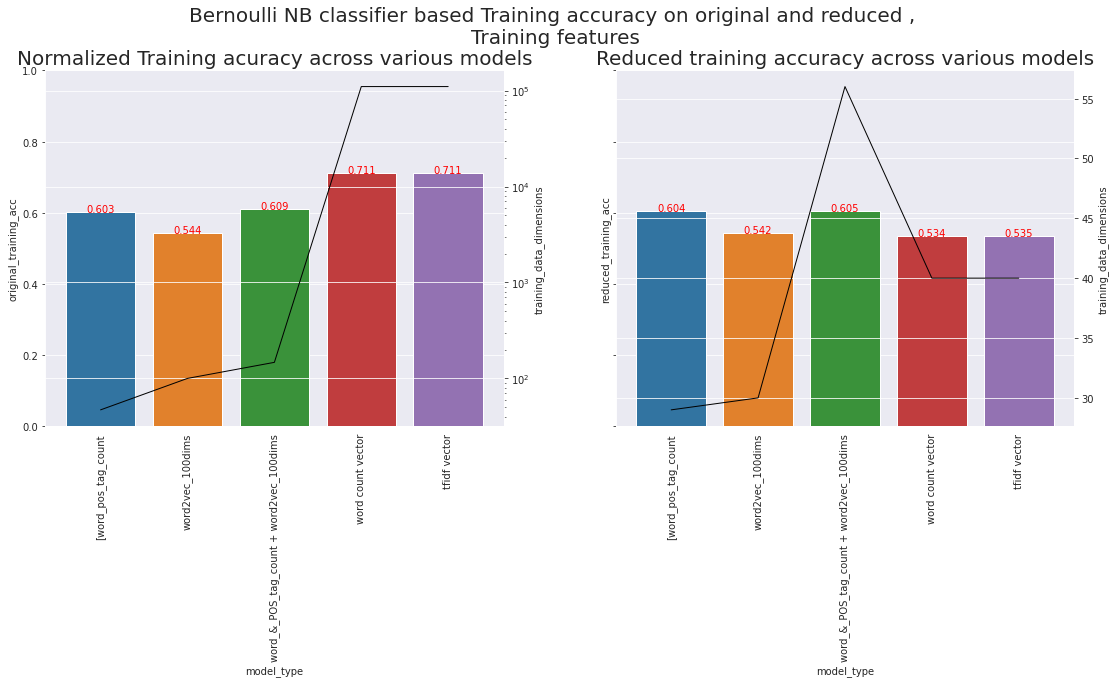

CPU times: user 11.6 s, sys: 2.26 s, total: 13.8 s
Wall time: 10.9 s


In [ ]:
%%time

# with joblib.parallel_backend('dask'):
# Automated approach for basic naive bayes classifier

print(word_vector_X_train.shape)
print(word_vector_X_train_reduced.shape)

print(tfidf_vector_X_test.shape)
print(tfidf_vector_X_train_reduced.shape)

X_Train_list_original=[word_pos_tag_count_X_train_normalized,
                      w2v_X_train_normalized,
                      combined_w2v_X_train_normalized,
                      word_vector_X_train,
                      tfidf_vector_X_train,
                      ]


X_Train_list_reduced=[word_pos_tag_count_X_train_reduced,
                      w2v_X_train_reduced,
                      combined_w2v_X_train_reduced,
                      word_vector_X_train_reduced,
                      tfidf_vector_X_train_reduced
                      ]

model_defn=['[word_pos_tag_count',
            'word2vec_100dims',
            'word_&_POS_tag_count + word2vec_100dims',
            'word count vector',
            'tfidf vector'

            ]

df=pd.DataFrame(columns=['model_type',
                        'original_dimensions',
                        'original_training_acc',
                        'reduced_dimensions',
                        'reduced_training_acc',])



for i in range(5):
  X_train_original=X_Train_list_original[i]
  X_train_reduced=X_Train_list_reduced[i]
  model_name=model_defn[i]
  
  nbclf=BernoulliNB() # for binary features
  nbclf.fit(X_train_original,y_train)

  nb_train_preds=nbclf.predict(X_train_original)
  nb_train_acc_original=accuracy_score(y_train, nb_train_preds)

  nbclf=BernoulliNB() # for binary features
  nbclf.fit(X_train_reduced,y_train)

  nb_train_preds=nbclf.predict(X_train_reduced)
  nb_train_acc_reduced=accuracy_score(y_train, nb_train_preds)
  

  df.at[i,'model_type']=model_name
  df.at[i,'original_dimensions']=X_train_original.shape[1]
  df.at[i,'original_training_acc']=nb_train_acc_original
  df.at[i,'reduced_dimensions']=X_train_reduced.shape[1]
  df.at[i,'reduced_training_acc']=nb_train_acc_reduced
  
  

print(df)

# Plotting accuracy
fig, (ax1, ax2)= plt.subplots(1, 2,sharey=True,figsize=(16,9))

fig.suptitle('Bernoulli NB classifier based Training accuracy on original and reduced , \n\
Training features',fontsize=20,x=0.5,y=1.05)


sns.barplot(data=df, x='model_type', y='original_training_acc',ax=ax1)
ax1.set_xticklabels(df['model_type'], rotation=90)
# ax1.set_xlabel('model_type',fontsize=15)
ax1.set_ylabel('original_training_acc',fontsize=10)
ax1.set_title('Normalized Training acuracy across various models',fontsize=20)
ax1.set_ylim(0, 1)
# Plotting the twin y axis for dimensions
axes2 = ax1.twinx()
axes2.set_yscale('log')
line1=axes2.plot(df['model_type'],df['original_dimensions'],'black',linewidth=1,label="metric_dims")
axes2.set_ylabel('training_data_dimensions',fontsize=10)

# Showing the labels in the barplot
for index, row in df.iterrows():
  ax1.text(row.name,row.original_training_acc, round(row.original_training_acc,3), color='red', ha="center")


sns.barplot(data=df, x='model_type', y='reduced_training_acc',ax=ax2)
ax2.set_xticklabels(df['model_type'], rotation=90)
ax2.set_xlabel('model_type',fontsize=10)
ax2.set_ylabel('reduced_training_acc',fontsize=10)
ax2.set_title('Reduced training accuracy across various models',fontsize=20)

# Plotting the twin y axis for dimensions
axes2 = ax2.twinx()
# axes2.set_yscale('log')
line1=axes2.plot(df['model_type'],df['reduced_dimensions'],'black',linewidth=1,label="metric_dims")
axes2.set_ylabel('training_data_dimensions',fontsize=10)

# Showing the labels in the barplot
for index, row in df.iterrows():
  ax2.text(row.name,row.reduced_training_acc, round(row.reduced_training_acc,3), color='red', ha="center")


fig.tight_layout()
plt.show()






INTERPRETATION

The reduced word+POS Tag Count +word 2 vec feature seems like a promising candidate for Clustering as it shows higher accuracy across original and reduced features, followed by word + pos tag count. Let's apply clustering on these features and see if there is any interesting insight.

While the sparse features of word count vector and tfidf vector have a higher accuracy originally, the accuracy dips upon reducing the dimensions. Hence we will not take them forward for clustering. 

# 7.1.Clustering

We will evaluate k means clustering GMM clustering on the reduced word +POS Tag count features as well as the normalized Word vector and tfidf Vector -see if we find any useful clusters.

We will not explore hierarchical clustering as they have O(kn^2) where k=number of clusters and n=number of data instances (https://www.sciencedirect.com/topics/computer-science/hierarchical-clustering) complexity, making them unsuitable for the large datasets for this task.

We will also overlay the training labels on the clusters and see if the clusters have any real-life alignment with the labels.

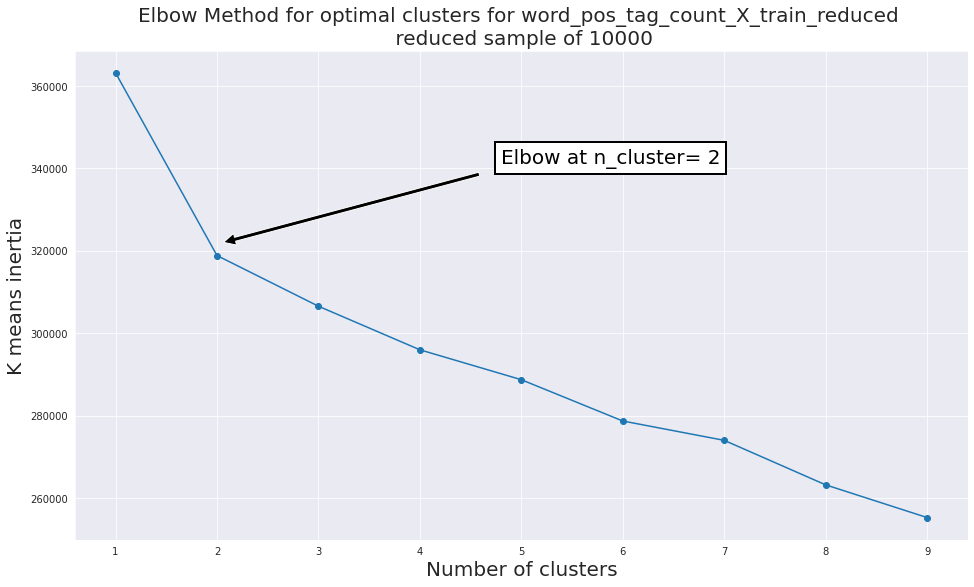

CPU times: user 17.4 s, sys: 6.99 s, total: 24.4 s
Wall time: 12.8 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
# How many clusters should we target for K means?
  elbw=[]
  for i in range(1,10):
    kmeans=KMeans(n_clusters=i,random_state=RANDOM_SEED)
    kmeans.fit(word_pos_tag_count_X_train_reduced[:10000,:])
    # kmeans.fit(combined_w2v_X_train_reduced)
    elbw.append(kmeans.inertia_)

  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()

  plt.plot(range(1,10),elbw,marker='o')
  plt.xlabel('Number of clusters',fontsize=20)
  plt.ylabel('K means inertia',fontsize=20)
  plt.title('Elbow Method for optimal clusters for word_pos_tag_count_X_train_reduced \n reduced sample of 10000',
            fontsize=20)

  plt.annotate('Elbow at n_cluster= 2',
                      color="black",fontsize=20, #fontweight='bold',
                      xy=(0.15, 0.6),  xycoords='axes fraction',
                      xytext=(.6, 0.8), textcoords='axes fraction',
                      arrowprops=dict(facecolor='k', shrink=0.05),
                      horizontalalignment='center', verticalalignment='top',
                      bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=2)
                      )
  
  
  plt.show()

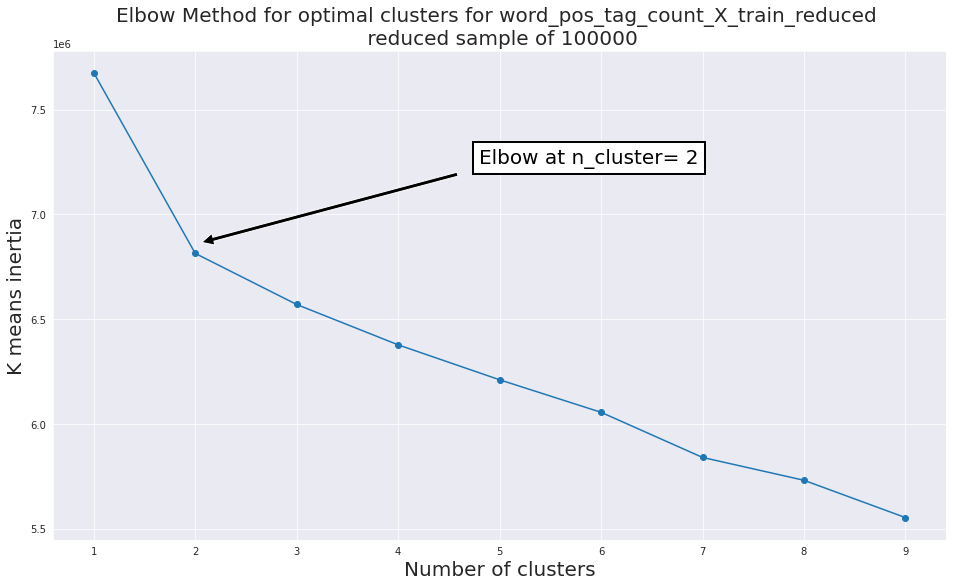

CPU times: user 2min 29s, sys: 26.3 s, total: 2min 55s
Wall time: 1min 30s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
# How many clusters should we target for K means?
  elbw=[]
  for i in range(1,10):
    kmeans=KMeans(n_clusters=i,random_state=RANDOM_SEED)
    kmeans.fit(word_pos_tag_count_X_train_reduced[100000:,:])
    # kmeans.fit(combined_w2v_X_train_reduced)
    elbw.append(kmeans.inertia_)
  
  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()

  plt.plot(range(1,10),elbw,marker='o')
  plt.xlabel('Number of clusters',fontsize=20)
  plt.ylabel('K means inertia',fontsize=20)
  plt.title('Elbow Method for optimal clusters for word_pos_tag_count_X_train_reduced \n reduced sample of 100000',
            fontsize=20)
  plt.annotate('Elbow at n_cluster= 2',
                      color="black",fontsize=20, #fontweight='bold',
                      xy=(0.15, 0.6),  xycoords='axes fraction',
                      xytext=(.6, 0.8), textcoords='axes fraction',
                      arrowprops=dict(facecolor='k', shrink=0.05),
                      horizontalalignment='center', verticalalignment='top',
                      bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=2)
                      )
  
  
  plt.show()

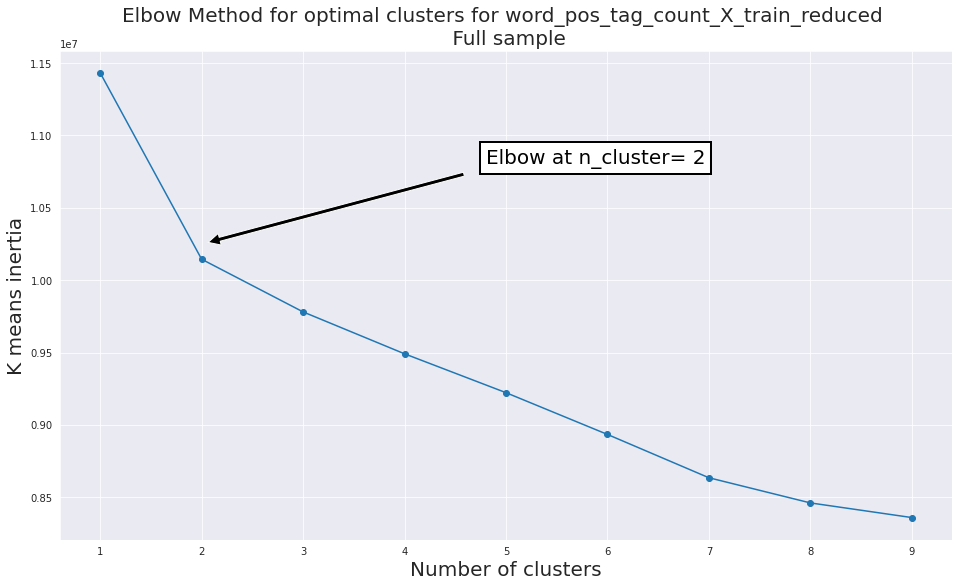

CPU times: user 4min 8s, sys: 40.4 s, total: 4min 49s
Wall time: 2min 28s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
# How many clusters should we target for K means?
  elbw=[]
  for i in range(1,10):
    kmeans=KMeans(n_clusters=i,random_state=RANDOM_SEED)
    kmeans.fit(word_pos_tag_count_X_train_reduced[:,:])
    # kmeans.fit(combined_w2v_X_train_reduced)
    elbw.append(kmeans.inertia_)
  
  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()

  plt.plot(range(1,10),elbw,marker='o')
  plt.xlabel('Number of clusters',fontsize=20)
  plt.ylabel('K means inertia',fontsize=20)
  plt.title('Elbow Method for optimal clusters for word_pos_tag_count_X_train_reduced \n Full sample',
            fontsize=20)
  plt.annotate('Elbow at n_cluster= 2',
                      color="black",fontsize=20, #fontweight='bold',
                      xy=(0.15, 0.6),  xycoords='axes fraction',
                      xytext=(.6, 0.8), textcoords='axes fraction',
                      arrowprops=dict(facecolor='k', shrink=0.05),
                      horizontalalignment='center', verticalalignment='top',
                      bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=2)
                      )
  
  
  plt.show()

INTERPRETATION

From the Elbow curve above for the word_pos_tag_count_X_train_reduced, we find that number of clusters =2 is optimal as that is where the 'elbow' is present in the curve. The curve becomes relatively straight after that point.

Lets apply the elbow rule to the combined_w2v_X_train_reduced feature, how many clusters would be optimal ?

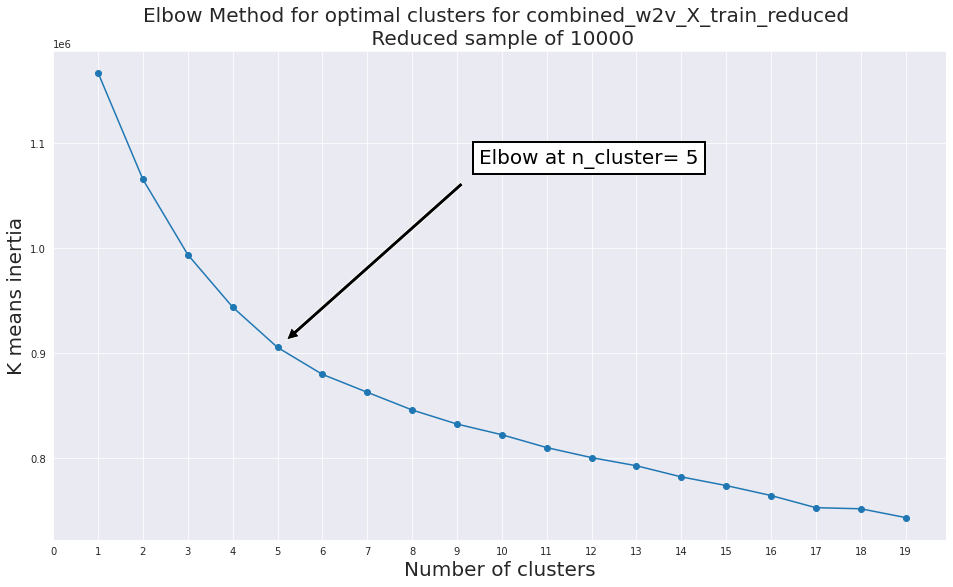

CPU times: user 1min 32s, sys: 36.8 s, total: 2min 9s
Wall time: 1min 6s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
# How many clusters should we target for K means?
  elbw=[]
  for i in range(1,20):
    kmeans=KMeans(n_clusters=i,random_state=RANDOM_SEED)
    kmeans.fit(combined_w2v_X_train_reduced[:10000,:])
    # kmeans.fit(combined_w2v_X_train_reduced)
    elbw.append(kmeans.inertia_)

  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()

  plt.plot(range(1,20),elbw,marker='o')
  plt.xticks(np.arange(0, 20, 1)) 
  plt.xlabel('Number of clusters',fontsize=20)
  plt.ylabel('K means inertia',fontsize=20)
  plt.title('Elbow Method for optimal clusters for combined_w2v_X_train_reduced \n Reduced sample of 10000',
            fontsize=20)
  
  plt.annotate('Elbow at n_cluster= 5',
                      color="black",fontsize=20, #fontweight='bold',
                      xy=(0.25, 0.39),  xycoords='axes fraction',
                      xytext=(.6, 0.8), textcoords='axes fraction',
                      arrowprops=dict(facecolor='k', shrink=0.05),
                      horizontalalignment='center', verticalalignment='top',
                      bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=2)
                      )
  
  
  plt.show()

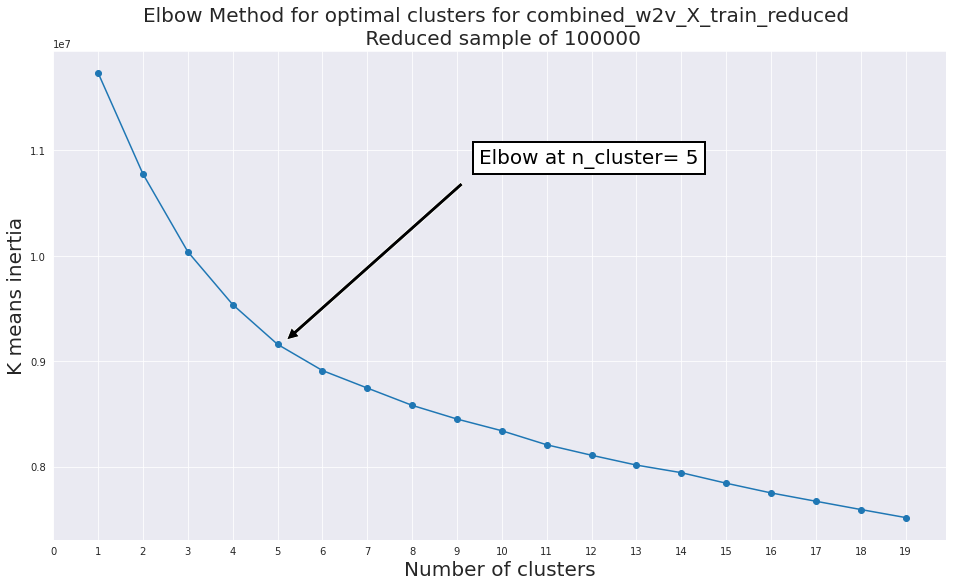

CPU times: user 9min 47s, sys: 2min 36s, total: 12min 24s
Wall time: 6min 20s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
# How many clusters should we target for K means?
  elbw=[]
  for i in range(1,20):
    kmeans=KMeans(n_clusters=i,random_state=RANDOM_SEED)
    kmeans.fit(combined_w2v_X_train_reduced[:100000,:])
    # kmeans.fit(combined_w2v_X_train_reduced)
    elbw.append(kmeans.inertia_)

  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()

  plt.plot(range(1,20),elbw,marker='o')
  plt.xticks(np.arange(0, 20, 1)) 
  plt.xlabel('Number of clusters',fontsize=20)
  plt.ylabel('K means inertia',fontsize=20)
  plt.title('Elbow Method for optimal clusters for combined_w2v_X_train_reduced \n Reduced sample of 100000',
            fontsize=20)
  
  plt.annotate('Elbow at n_cluster= 5',
                      color="black",fontsize=20, #fontweight='bold',
                      xy=(0.25, 0.39),  xycoords='axes fraction',
                      xytext=(.6, 0.8), textcoords='axes fraction',
                      arrowprops=dict(facecolor='k', shrink=0.05),
                      horizontalalignment='center', verticalalignment='top',
                      bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=2)
                      )
  
  
  plt.show()

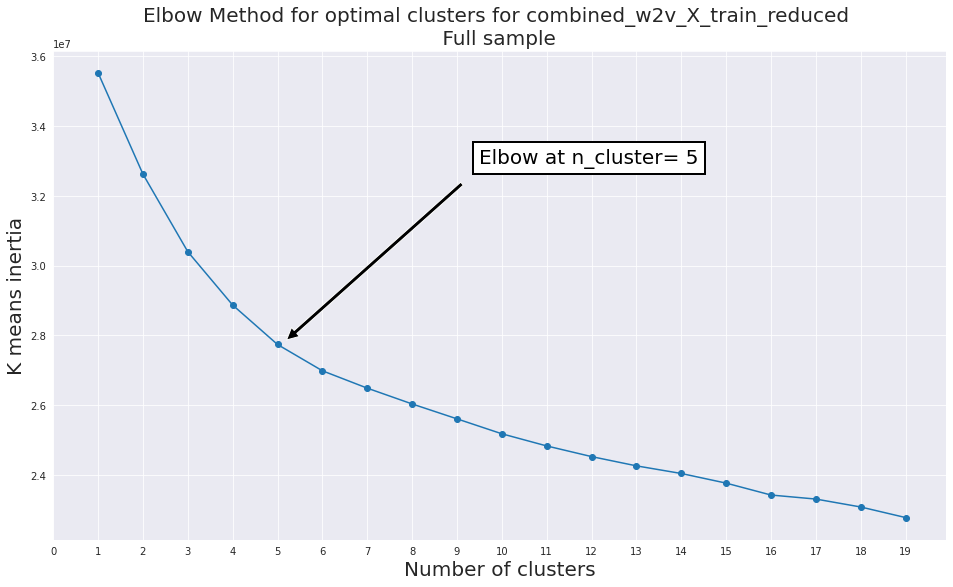

CPU times: user 25min 9s, sys: 5min 56s, total: 31min 6s
Wall time: 16min 9s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
# How many clusters should we target for K means?
  elbw=[]
  for i in range(1,20):
    kmeans=KMeans(n_clusters=i,random_state=RANDOM_SEED)
    kmeans.fit(combined_w2v_X_train_reduced[:,:])
    # kmeans.fit(combined_w2v_X_train_reduced)
    elbw.append(kmeans.inertia_)

  fig = plt.figure(figsize=(16,9))
  ax = fig.add_subplot()

  plt.plot(range(1,20),elbw,marker='o')
  plt.xticks(np.arange(0, 20, 1)) 
  plt.xlabel('Number of clusters',fontsize=20)
  plt.ylabel('K means inertia',fontsize=20)
  plt.title('Elbow Method for optimal clusters for combined_w2v_X_train_reduced \n Full sample ',
            fontsize=20)
  
  plt.annotate('Elbow at n_cluster= 5',
                      color="black",fontsize=20, #fontweight='bold',
                      xy=(0.25, 0.39),  xycoords='axes fraction',
                      xytext=(.6, 0.8), textcoords='axes fraction',
                      arrowprops=dict(facecolor='k', shrink=0.05),
                      horizontalalignment='center', verticalalignment='top',
                      bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=2)
                      )
  
  
  plt.show()

INTERPRETATION

There is a gentle elbow at k=5 clusters for combined_w2v_X_train_reduced

Now that we know the optimal clusters for word_pos_tag_count_X_train_reduced and combined_w2v_X_train_reduced, lets fit the K means on them as well a Cluster probability predictor (GMM with relevant component size) using the same cluster number of k=2 for vword_pos_tag_count_X_train_reduced and k=5 for combined_w2v_X_train_reduced.

We are using GMM as it is flexible on cluster shapes (unlike k means which need spherical clusters) and also has probabilistic cluster assignment (soft clustering). (https://analyticsindiamag.com/gaussian-mixture-model-clustering-vs-k-means-which-one-to-choose/).

In [ ]:
%%time
# Kmeans for word_pos_tag_count_X_train_reduced
kmeans1=KMeans(n_clusters=2,random_state=RANDOM_SEED)
kmeans1.fit(word_pos_tag_count_X_train_reduced[:,:])

kmeans1_dev=KMeans(n_clusters=2,random_state=RANDOM_SEED)
kmeans1_dev.fit(word_pos_tag_count_X_dev_reduced)

kmeans1_test=KMeans(n_clusters=2,random_state=RANDOM_SEED)
kmeans1_test.fit(word_pos_tag_count_X_test_reduced)

# Kmeans for combined_w2v_X_train_reduced
kmeans2=KMeans(n_clusters=5,random_state=RANDOM_SEED)
kmeans2.fit(combined_w2v_X_train_reduced[:,:])

kmeans2_dev=KMeans(n_clusters=5,random_state=RANDOM_SEED)
kmeans2_dev.fit(combined_w2v_X_dev_reduced[:,:])

kmeans2_test=KMeans(n_clusters=5,random_state=RANDOM_SEED)
kmeans2_test.fit(combined_w2v_X_test_reduced[:,:])

CPU times: user 1min 10s, sys: 7.69 s, total: 1min 17s
Wall time: 40.6 s


In [ ]:
%%time
# GMM for word_pos_tag_count_X_train_reduced
GMM1=GaussianMixture(n_components=2,random_state=RANDOM_SEED)
GMM1.fit(word_pos_tag_count_X_train_reduced)

GMM1_dev=GaussianMixture(n_components=2,random_state=RANDOM_SEED)
GMM1_dev.fit(word_pos_tag_count_X_dev_reduced)

GMM1_test=GaussianMixture(n_components=2,random_state=RANDOM_SEED)
GMM1_test.fit(word_pos_tag_count_X_test_reduced)

# predicted clusters from GMM for word_pos_tag_count_X_train_reduced
clusters_GMM1=GMM1.predict(word_pos_tag_count_X_train_reduced)

# GMM for combined_w2v_X_train_reduced
GMM2=GaussianMixture(n_components=5,random_state=RANDOM_SEED)
GMM2.fit(combined_w2v_X_train_reduced)

GMM2_dev=GaussianMixture(n_components=5,random_state=RANDOM_SEED)
GMM2_dev.fit(combined_w2v_X_dev_reduced)

GMM2_test=GaussianMixture(n_components=5,random_state=RANDOM_SEED)
GMM2_test.fit(combined_w2v_X_test_reduced)

# predicted clusters from GMM for word_pos_tag_count_X_train_reduced
clusters_GMM2=GMM2.predict(combined_w2v_X_train_reduced)


CPU times: user 3min 17s, sys: 1min 20s, total: 4min 38s
Wall time: 2min 26s


Can we use the GMM Cluster probabilities as a feature for label prediction ?

In [ ]:
%%time
# Deriving the cluster probabibilities
GMM1_probs = GMM1.predict_proba(word_pos_tag_count_X_train_reduced)

GMM2_probs = GMM2.predict_proba(combined_w2v_X_train_reduced)

CPU times: user 2.61 s, sys: 885 ms, total: 3.5 s
Wall time: 2.02 s


In [ ]:
print(GMM1_probs.shape)
print(GMM2_probs.shape)

(300462, 2)
(300462, 5)


Let's see how the GMM cluster probabilities fare vs the original features on which these GMM clusters were created -on Training accuracy

                                          model_type  ... reduced_training_acc
0                                 word_pos_tag_count  ...              0.60373
1            word_&_POS_tag_count + word2vec_100dims  ...             0.604978
2                    2cluster_GMM_word_pos_tag_count  ...             0.515879
3  5cluster_GMM_word_&_POS_tag_count + word2vec_1...  ...             0.522715

[4 rows x 3 columns]


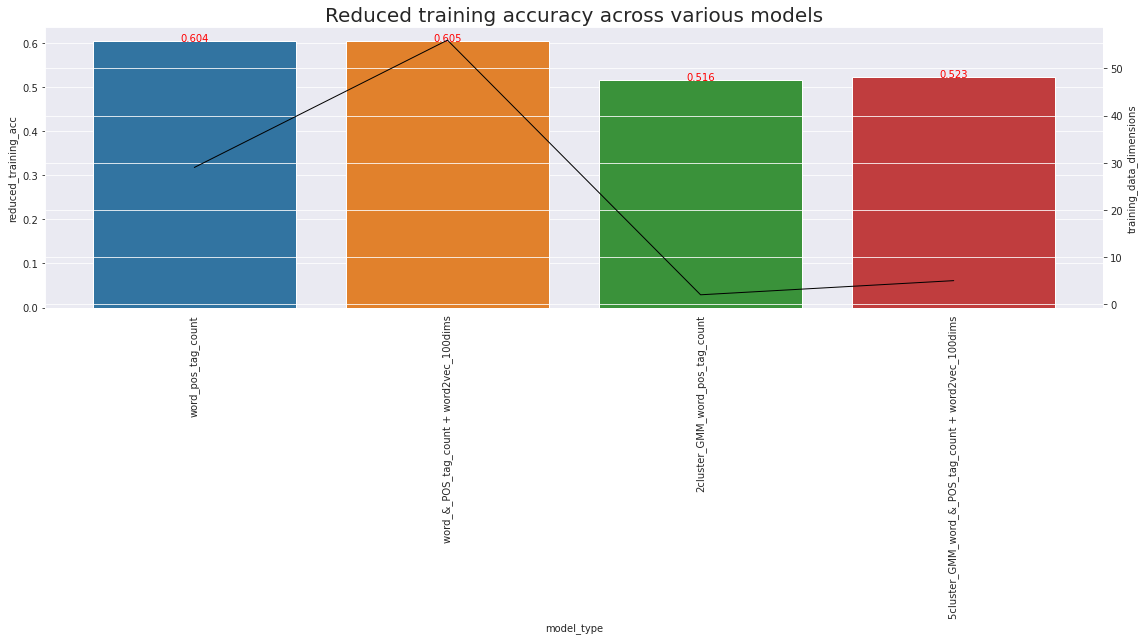

CPU times: user 3.19 s, sys: 851 ms, total: 4.04 s
Wall time: 3.05 s


In [ ]:
%%time

# with joblib.parallel_backend('dask'):
# Automated approach for basic naive bayes classifier



X_Train_list_reduced=[word_pos_tag_count_X_train_reduced,
                      combined_w2v_X_train_reduced,
                      GMM1_probs,
                      GMM2_probs
                      ]

model_defn=['word_pos_tag_count',
            'word_&_POS_tag_count + word2vec_100dims',
            '2cluster_GMM_word_pos_tag_count',
            '5cluster_GMM_word_&_POS_tag_count + word2vec_100dims',
            ]

df=pd.DataFrame(columns=['model_type',
                        'reduced_dimensions',
                        'reduced_training_acc',])



for i in range(4):
  
  X_train_reduced=X_Train_list_reduced[i]
  model_name=model_defn[i]
  
  nbclf=BernoulliNB() # for binary features
  nbclf.fit(X_train_reduced,y_train)

  nb_train_preds=nbclf.predict(X_train_reduced)
  nb_train_acc_reduced=accuracy_score(y_train, nb_train_preds)
  

  df.at[i,'model_type']=model_name
  df.at[i,'reduced_dimensions']=X_train_reduced.shape[1]
  df.at[i,'reduced_training_acc']=nb_train_acc_reduced
  
  

print(df)

# Plotting accuracy
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

# # fig, (ax1, ax2)= plt.subplots(2, 1,sharex=True,figsize=(16,9))

# # fig.suptitle('Bernoulli NB classifier based Training accuracy on reduced , \n\
# # Training features and GMM cluster probabilities ',fontsize=20,x=0.5,y=1.05)


# sns.barplot(data=df, x='model_type', y='original_training_acc',ax=ax)
# ax.set_xticklabels(df['model_type'], rotation=90)
# # ax1.set_xlabel('model_type',fontsize=15)
# ax.set_ylabel('training_acc',fontsize=10)
# ax.set_title('Training acuracy across various models',fontsize=20)

# # Plotting the twin y axis for dimensions
# axes2 = ax.twinx()
# axes2.set_yscale('log')
# line1=axes2.plot(df['model_type'],df['reduced_dimensions'],'black',linewidth=1,label="metric_dims")
# axes2.set_ylabel('reduced_data_dimensions',fontsize=10)

# # Showing the labels in the barplot
# for index, row in df.iterrows():
#   ax.text(row.name,row.reduced_training_acc, round(row.reduced_training_acc,3), color='red', ha="center")


sns.barplot(data=df, x='model_type', y='reduced_training_acc',ax=ax)
ax.set_xticklabels(df['model_type'], rotation=90)
ax.set_xlabel('model_type',fontsize=10)
ax.set_ylabel('reduced_training_acc',fontsize=10)
ax.set_title('Reduced training accuracy across various models',fontsize=20)

# Plotting the twin y axis for dimensions
axes2 = ax.twinx()
# axes2.set_yscale('log')
line1=axes2.plot(df['model_type'],df['reduced_dimensions'],'black',linewidth=1,label="metric_dims")
axes2.set_ylabel('training_data_dimensions',fontsize=10)

# Showing the labels in the barplot
for index, row in df.iterrows():
  ax.text(row.name,row.reduced_training_acc, round(row.reduced_training_acc,3), color='red', ha="center")


fig.tight_layout()
plt.show()






INTERPRETATION

This is a revelation !

That the GMM cluster probabilities have a training accuracy >50% (only a tad better than uniform random baseline) which we have seen in the Feature Engineering notebook.

While the cluster probabilities are not able to achieve high accuracy on their own -may be they can be added to other features to augment their accuracy ?

Thus, we will save the following features sets as a pickle later to take forward in the supervised pipeline phase :
1. word_pos_tag_count_X_train_reduced,
2. combined_w2v_X_train_reduced,
3. GMM1_probs,
4. GMM2_probs

We had earlier seen UMAP to perform relatively well (computationally speaking) on the various data structure visualization techniques, relative to MDS and tSNE.

Let's revisit UMAP to identify a cluster structure of around 2 which would tie it with the optimal clusters we found above. We will use the reduced data set here and iterate with various UMAP hyperparameters to get a global topography with local nuances.

Let's start by various UMAP hyperparameters like n_neighbors and min_dist on the word_pos_tag_count_X_train_reduced feature set.

We will build the model gradually by exploring the hyperparameters and increasing the sample size of the data used to fit the model.

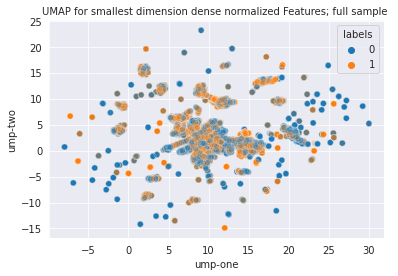

CPU times: user 6min 24s, sys: 26.2 s, total: 6min 50s
Wall time: 5min 14s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=20,min_dist=0,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:100000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:100000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 100000 sample ',fontsize=10)

  plt.show()



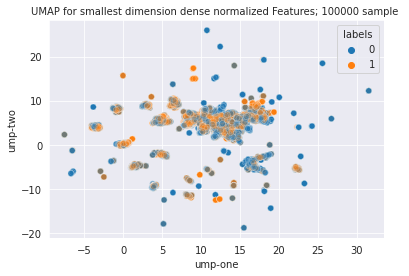

CPU times: user 8min 57s, sys: 36.1 s, total: 9min 33s
Wall time: 7min 31s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=50,min_dist=0,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:100000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:100000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 100000 sample ',fontsize=10)

  plt.show()



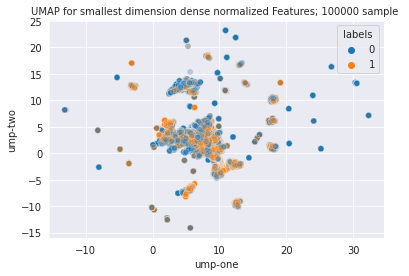

CPU times: user 14min 2s, sys: 55.7 s, total: 14min 58s
Wall time: 11min 3s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=100,min_dist=0,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:100000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:100000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 100000 sample ',fontsize=10)

  plt.show()



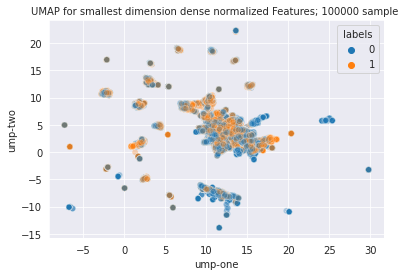

CPU times: user 17min 35s, sys: 1min 9s, total: 18min 44s
Wall time: 13min 34s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=150,min_dist=0,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:10000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:100000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 100000 sample ',fontsize=10)

  plt.show()



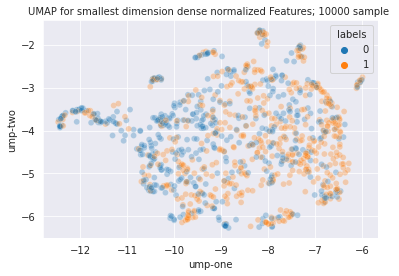

CPU times: user 9.53 s, sys: 236 ms, total: 9.76 s
Wall time: 9.45 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:1000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:1000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 1000 sample ',fontsize=10)

  plt.show()



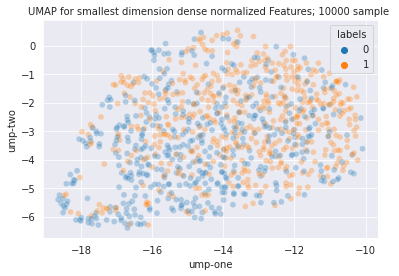

CPU times: user 10 s, sys: 254 ms, total: 10.3 s
Wall time: 9.96 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0.5,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:1000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:1000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 1000 sample ',fontsize=10)

  plt.show()



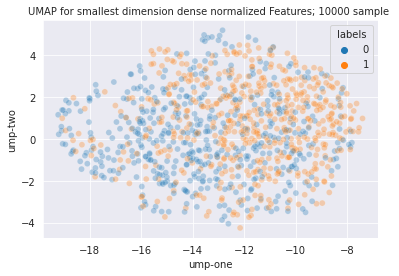

CPU times: user 9.74 s, sys: 260 ms, total: 10 s
Wall time: 9.64 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=150,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:1000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:1000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 1000 sample ',fontsize=10)

  plt.show()



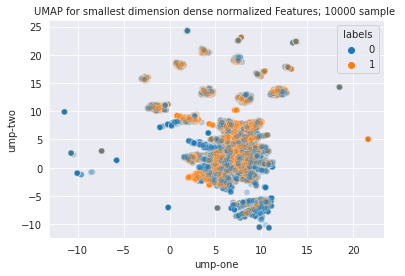

CPU times: user 15min 20s, sys: 35.1 s, total: 15min 55s
Wall time: 11min 32s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=190,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:100000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:100000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features; 10000 sample ',fontsize=10)

  plt.show()



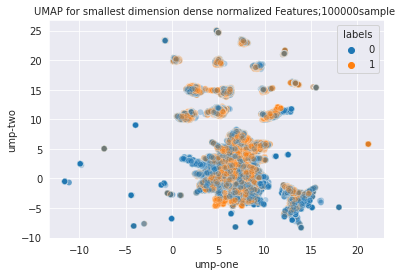

CPU times: user 15min 33s, sys: 41.1 s, total: 16min 14s
Wall time: 11min 46s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=200,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=100000
  # Running UMAP on a reduced sample
  featur=word_pos_tag_count_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df1=pd.DataFrame()
  ump_df1['ump-one'] = ump11[:,0]
  ump_df1['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df1['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df1,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for smallest dimension dense normalized Features;' + str(row_num)+'sample ',fontsize=10)

  plt.show()



INTERPRETATION

We will use this structure visualization of word_pos_tag_count_X_train_reduced and overlay the k means and GMM cluster labels to see how they perform vs the original training labels. The reason we choose this structure is because it is able to bring out some differentiation, some parts of the data separated from the central overlaid mass

The whole analysis was conducted on a sample of 100,000 as we are not able to compute UMAP on whole sample due to computational limitations.

Running UMAP on the combined_w2v_X_train_reduced to understand the structure, by tweaking the hyperparameters of n_neighbors and min_dist.

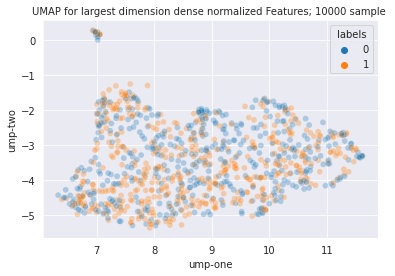

CPU times: user 9.56 s, sys: 266 ms, total: 9.83 s
Wall time: 9.5 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:1000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:1000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for largest dimension dense normalized Features; 10000 sample ',fontsize=10)

  plt.show()



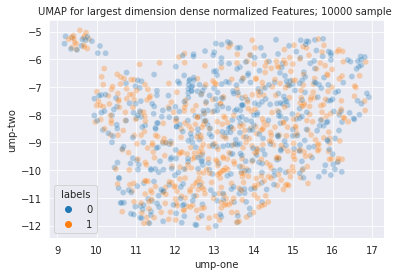

CPU times: user 10 s, sys: 275 ms, total: 10.3 s
Wall time: 9.97 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0.5,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:1000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:1000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for largest dimension dense normalized Features; 10000 sample ',fontsize=10)

  plt.show()



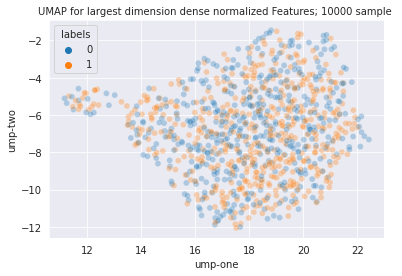

CPU times: user 10 s, sys: 221 ms, total: 10.2 s
Wall time: 9.89 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:1000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:1000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for largest dimension dense normalized Features; 10000 sample ',fontsize=10)

  plt.show()



/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


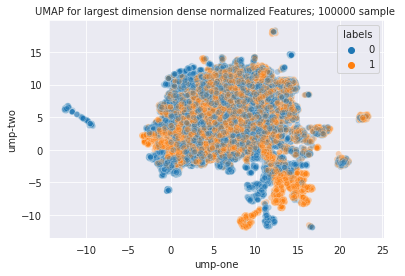

CPU times: user 16min 39s, sys: 37.1 s, total: 17min 16s
Wall time: 12min


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100

  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:100000,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:100000]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for largest dimension dense normalized Features; 100000 sample ',fontsize=10)

  plt.show()



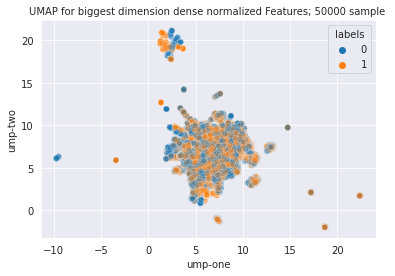

CPU times: user 7min 8s, sys: 11 s, total: 7min 19s
Wall time: 5min 10s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



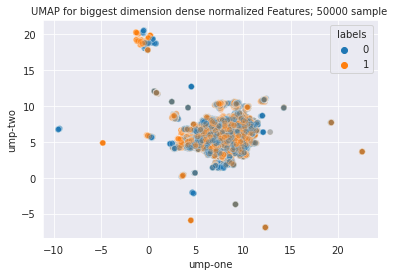

CPU times: user 7min 9s, sys: 10.1 s, total: 7min 19s
Wall time: 5min 11s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=180,min_dist=0.05,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



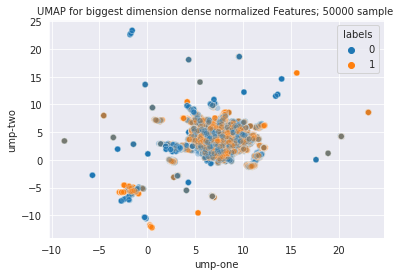

CPU times: user 18min 57s, sys: 44 s, total: 19min 41s
Wall time: 13min 38s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=200,min_dist=0.05,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=100000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



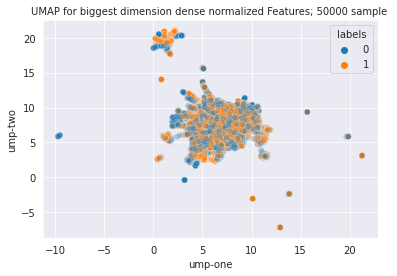

CPU times: user 6min 18s, sys: 8.51 s, total: 6min 26s
Wall time: 4min 36s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=150,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



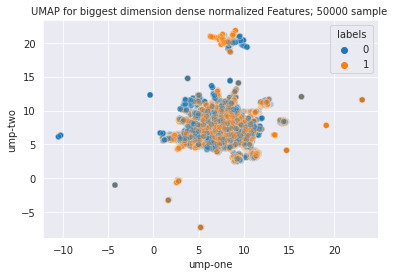

CPU times: user 4min 30s, sys: 6.76 s, total: 4min 37s
Wall time: 3min 30s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=100,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



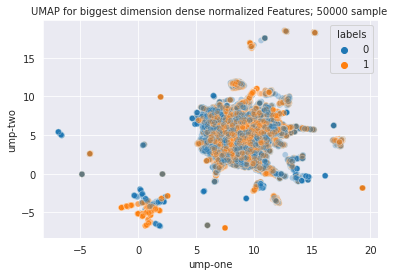

CPU times: user 2min 49s, sys: 6.25 s, total: 2min 56s
Wall time: 2min 22s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=50,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



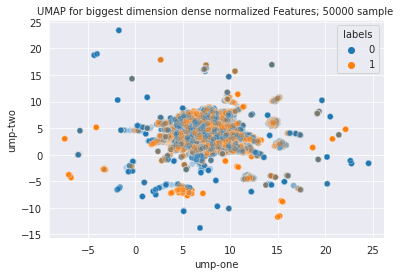

CPU times: user 7min 5s, sys: 24.1 s, total: 7min 29s
Wall time: 5min 56s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=50,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=100000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 100000 sample ',fontsize=10)

  plt.show()



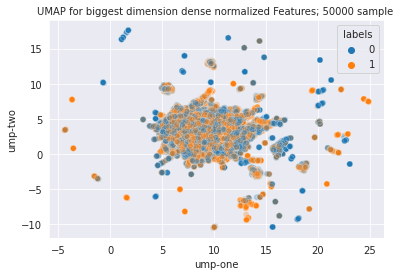

CPU times: user 1min 54s, sys: 5.24 s, total: 1min 59s
Wall time: 1min 38s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=20,min_dist=0.15,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



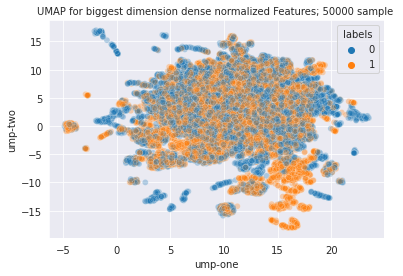

CPU times: user 1min 54s, sys: 5.3 s, total: 2min
Wall time: 1min 39s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=20,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



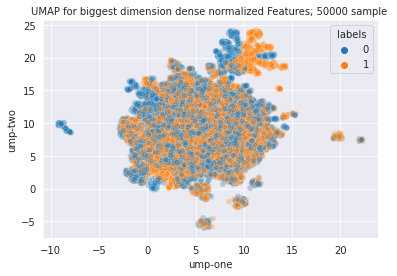

CPU times: user 4min 30s, sys: 6.66 s, total: 4min 36s
Wall time: 3min 30s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=100,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



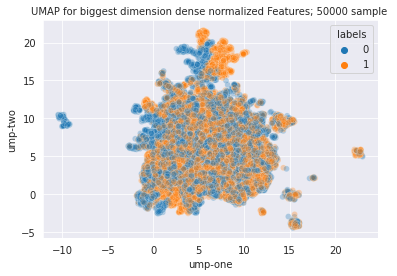

CPU times: user 6min 29s, sys: 9.23 s, total: 6min 38s
Wall time: 4min 48s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=150,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



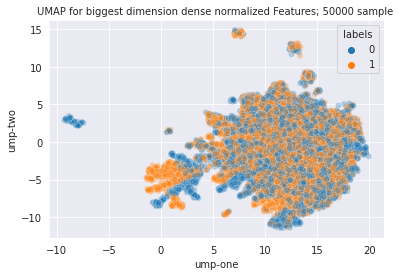

CPU times: user 8min 47s, sys: 12.9 s, total: 9min
Wall time: 6min 9s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=200,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=50000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features; 50000 sample ',fontsize=10)

  plt.show()



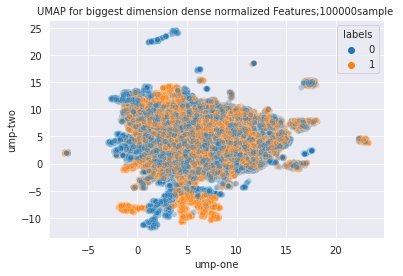

CPU times: user 19min 6s, sys: 48.5 s, total: 19min 54s
Wall time: 13min 50s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  ump=umap.UMAP(n_neighbors=200,min_dist=0.99,random_state=RANDOM_SEED) # n_neighbors=100
  row_num=100000
  # Running UMAP on a reduced sample
  featur=combined_w2v_X_train_reduced[:row_num,:]

  ump11=ump.fit_transform(featur)
    
  # Setting up the Visualization dataframe
  ump_df2=pd.DataFrame()
  ump_df2['ump-one'] = ump11[:,0]
  ump_df2['ump-two'] = ump11[:,1]

  # Adding training labels
  ump_df2['labels']=y_train[:row_num]

    # Visualizing the 1st 2 UMAP components, also overlaying the labels
  
  sns.scatterplot(
    x="ump-one", y="ump-two",
    hue="labels",
    data=ump_df2,
    legend="full",
    alpha=0.3,
  )

  plt.title('UMAP for biggest dimension dense normalized Features;'+str(row_num)+'sample ',fontsize=10)

  plt.show()



INTERPRETATION 

We will use this structure visualization for the higher dimension features combined_w2v_X_train_reduced.


However we observe that the data is quite packed together from a different label perspective -so that we could not break away any substantial chunk of the data with a single label.

However we did manage to identify the bottom region in the plot above which has clear regions of both labels without overlap. It would be interesting to know how this region is identified by cluster algorithms.

Again, due to computational resource limitation we had to limit the visualization to 100,000 instances .

Let's, now visualize how the 2 different cluster labels -from Kmeans and GMM for the same number of clusters stack up against the original label visually

What is the class balance across Training label vs K means vs GMM on word_pos_tag_count_X_train_reduced structure (100,000 sample)

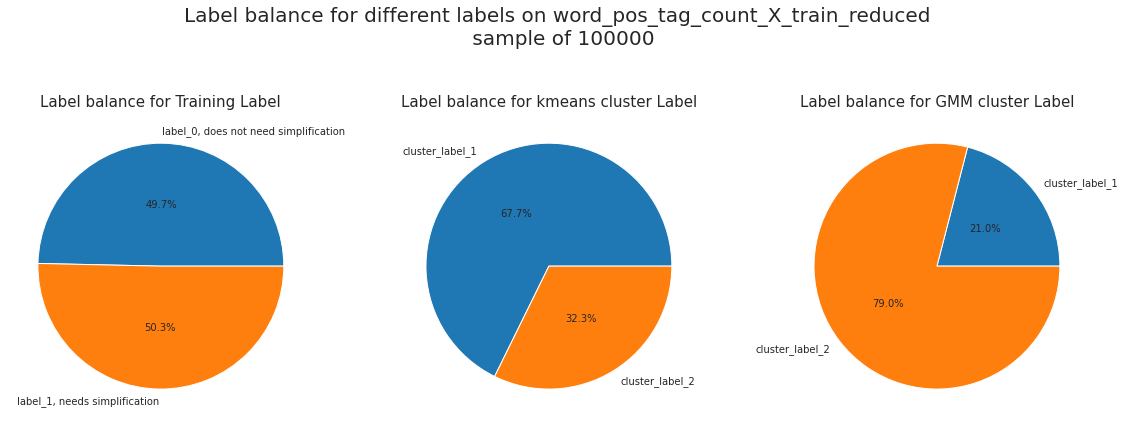

In [ ]:
fig, (ax1, ax2,ax3)= plt.subplots(1, 3,figsize=(16,9))
fig.suptitle('Label balance for different labels on word_pos_tag_count_X_train_reduced \n sample of 100000',
             fontsize=20,x=0.5,y=.9)
plotted_sample=100000
lbl_lst1=['label_0, does not need simplification','label_1, needs simplification']
lbl_lst2=['cluster_label_1','cluster_label_2']

y=np.array(y_train[:plotted_sample])
x0=np.count_nonzero(y == 0)/len(y)
x1=np.count_nonzero(y == 1)/len(y)
vals=[x0,x1]

ax1.pie(vals,labels=lbl_lst1,autopct="%.1f%%", pctdistance=0.5)
ax1.set_title('Label balance for Training Label',fontsize=15)


y=np.array(kmeans1.labels_[:plotted_sample])
x0=np.count_nonzero(y == 0)/len(y)
x1=np.count_nonzero(y == 1)/len(y)
vals=[x0,x1]

ax2.pie(vals,labels=lbl_lst2,autopct="%.1f%%", pctdistance=0.5)
ax2.set_title('Label balance for kmeans cluster Label',fontsize=15)


y=np.array(clusters_GMM1[:plotted_sample])
x0=np.count_nonzero(y == 0)/len(y)
x1=np.count_nonzero(y == 1)/len(y)
vals=[x0,x1]

ax3.pie(vals,labels=lbl_lst2,autopct="%.1f%%", pctdistance=0.5)
ax3.set_title('Label balance for GMM cluster Label',fontsize=15)

plt.tight_layout()
plt.show()




INTERPRETATION

The split of K means clusters seems closer to the training labels -though there is still a a large difference.

Are their structures similar ?

Let's check the UMAP cluster structures

Training label vs K means vs GMM on word_pos_tag_count_X_train_reduced structure (100,000 sample)

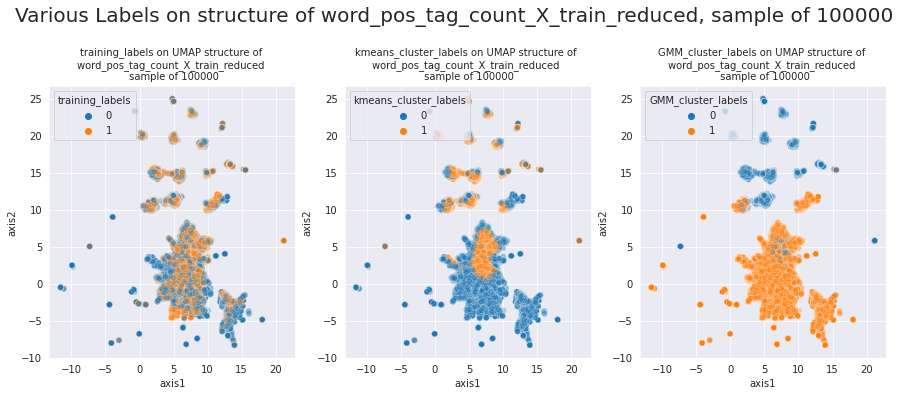

CPU times: user 13.3 s, sys: 2.65 s, total: 16 s
Wall time: 13.1 s


In [ ]:
%%time

# with joblib.parallel_backend('dask'):
plotted_sample=100000
fig, (ax1, ax2,
ax3)= plt.subplots(1, 3,figsize=(15,5))
fig.suptitle('Various Labels on structure of word_pos_tag_count_X_train_reduced, sample of '+str(plotted_sample),
        fontsize=20,x=0.5,y=1.1)



# ftr_lst=[word_pos_tag_count_X_train_normalized,w2v_X_train_normalized,
#         combined_w2v_X_train_normalized]

# Label_type1=[training_labels,kmeans_cluster_labels,
#     GMM_cluster_labels]


Label_type2=['training_labels','kmeans_cluster_labels',
    'GMM_cluster_labels']

ax_lst=[ax1,ax2,ax3]

for idx,val in enumerate(ax_lst):
  ax=ax_lst[idx]
  # lbl1=Label_type1[idx]
  lbl2=Label_type2[idx]

  # Visualizing the clusters for combined_w2v_X_train_reduced
  plotted_sample=100000
  df2=pd.DataFrame()
  df2['axis1']=ump_df1.loc[:plotted_sample,'ump-one']
  df2['axis2']=ump_df1.loc[:plotted_sample,'ump-two']
  df2['training_labels']=y_train[:plotted_sample]
  df2['kmeans_cluster_labels']=kmeans1.labels_[:plotted_sample]
  df2['GMM_cluster_labels']=clusters_GMM1[:plotted_sample]

  sns.scatterplot(
    x="axis1", y="axis2",
    hue=lbl2,
    data=df2,
    # legend="full",
    alpha=0.3,ax=ax
  )

  ax.legend(loc=2,title=lbl2)

  ax.set_title(lbl2+' on UMAP structure of \nword_pos_tag_count_X_train_reduced \n sample of '+str(plotted_sample),fontsize=10)

    
plt.show()



INTERPRETATION

Training label vs K means vs GMM on combined_w2v_X_train_reduced structure (100,000 sample)

For the smaller dimension feature, kmeans seems to provide better cluster than GMM. Kmeans labels seem to overlap with the training data labels while GMM is mostly concentrated by label 1. This is possibly aligned with the fact that split of labels in K means is a bit closer to that of the training labels.

Let's see if this pattern is reflected in the actual cluster evaluation metrics -especially the metrics using ground truth labels.

What is the class balance across Training label vs K means vs GMM on combined_w2v_X_train_reduced structure (100,000 sample)

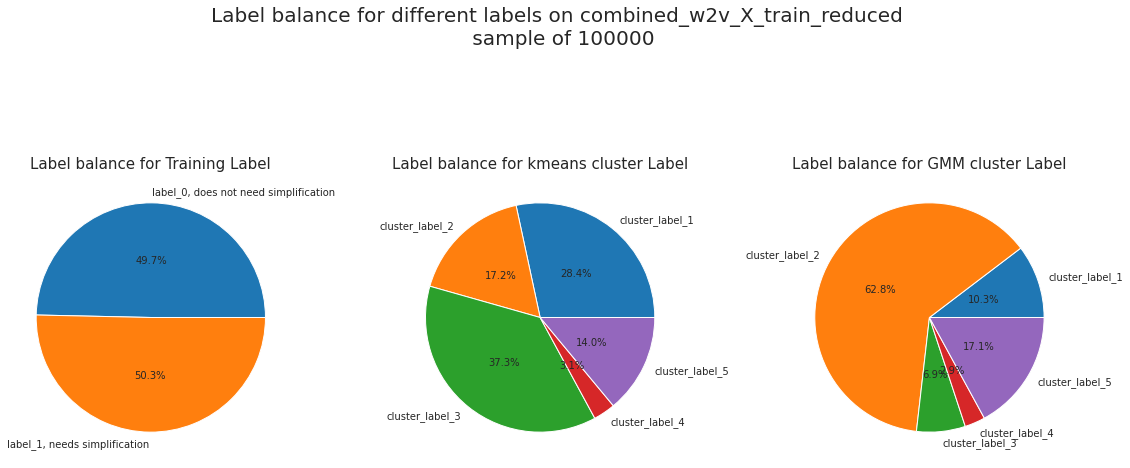

In [ ]:
fig, (ax1, ax2,ax3)= plt.subplots(1, 3,figsize=(16,9))
fig.suptitle('Label balance for different labels on combined_w2v_X_train_reduced \n sample of 100000',
             fontsize=20,x=0.5,y=.98)
plotted_sample=100000
lbl_lst1=['label_0, does not need simplification','label_1, needs simplification']
lbl_lst2=['cluster_label_1','cluster_label_2',
          'cluster_label_3','cluster_label_4',
          'cluster_label_5']

y=np.array(y_train[:plotted_sample])
x0=np.count_nonzero(y == 0)/len(y)
x1=np.count_nonzero(y == 1)/len(y)
vals=[x0,x1]

ax1.pie(vals,labels=lbl_lst1,autopct="%.1f%%", pctdistance=0.5)
ax1.set_title('Label balance for Training Label',fontsize=15)


y=np.array(kmeans2.labels_[:plotted_sample])
x0=np.count_nonzero(y == 0)/len(y)
x1=np.count_nonzero(y == 1)/len(y)
x2=np.count_nonzero(y == 2)/len(y)
x3=np.count_nonzero(y == 3)/len(y)
x4=np.count_nonzero(y == 4)/len(y)

vals=[x0,x1,x2,x3,x4]

ax2.pie(vals,labels=lbl_lst2,autopct="%.1f%%", pctdistance=0.5)
ax2.set_title('Label balance for kmeans cluster Label',fontsize=15)


y=np.array(clusters_GMM2[:plotted_sample])
x0=np.count_nonzero(y == 0)/len(y)
x1=np.count_nonzero(y == 1)/len(y)
x2=np.count_nonzero(y == 2)/len(y)
x3=np.count_nonzero(y == 3)/len(y)
x4=np.count_nonzero(y == 4)/len(y)

vals=[x0,x1,x2,x3,x4]

ax3.pie(vals,labels=lbl_lst2,autopct="%.1f%%", pctdistance=0.5)
ax3.set_title('Label balance for GMM cluster Label',fontsize=15)

plt.tight_layout()
plt.show()


INTERPRETATION

Here , K means has more equally portioned clusters than GMM where a single cluster dominates.

Let's see from the structure visualization if the bottom -non overlap region for the combined_w2v_X_train_reduced in the UMAP gets captured -with its difference in labels.

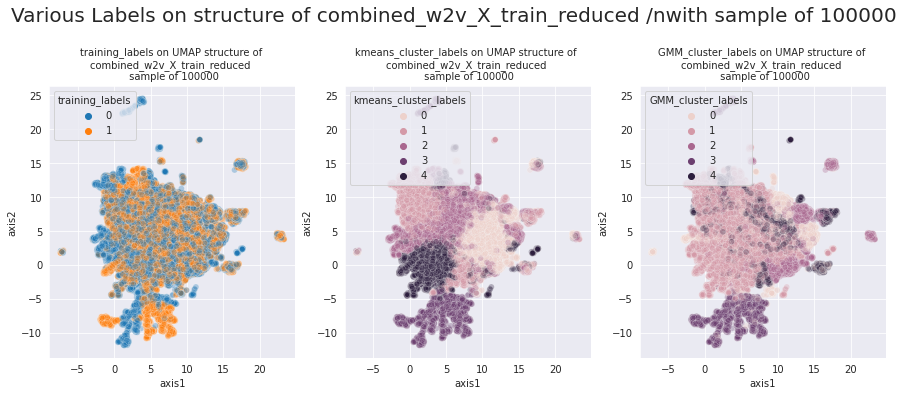

In [ ]:
# %%time

# with joblib.parallel_backend('dask'):
plotted_sample=100000
fig, (ax1, ax2,ax3)= plt.subplots(1, 3,figsize=(15,5))
fig.suptitle('Various Labels on structure of combined_w2v_X_train_reduced /nwith sample of '+str(plotted_sample),
        fontsize=20,x=0.5,y=1.1)


# ftr_lst=[word_pos_tag_count_X_train_normalized,w2v_X_train_normalized,
#         combined_w2v_X_train_normalized]

# Label_type1=[training_labels,kmeans_cluster_labels,
#     GMM_cluster_labels]


Label_type2=['training_labels','kmeans_cluster_labels',
    'GMM_cluster_labels']

ax_lst=[ax1,ax2,ax3]

for idx,val in enumerate(ax_lst):
  ax=ax_lst[idx]
  # lbl1=Label_type1[idx]
  lbl2=Label_type2[idx]

  # Visualizing the clusters for combined_w2v_X_train_reduced
  
  df2=pd.DataFrame()
  df2['axis1']=ump_df2.loc[:plotted_sample,'ump-one']
  df2['axis2']=ump_df2.loc[:plotted_sample,'ump-two']
  df2['training_labels']=y_train[:plotted_sample]
  df2['kmeans_cluster_labels']=kmeans2.labels_[:plotted_sample]
  df2['GMM_cluster_labels']=clusters_GMM2[:plotted_sample]

  sns.scatterplot(
    x="axis1", y="axis2",
    hue=lbl2,
    data=df2,
    # legend="full",
    alpha=0.3,ax=ax
  )

  ax.legend(loc=2,title=lbl2)

  ax.set_title(lbl2+' on UMAP structure of \ncombined_w2v_X_train_reduced \n sample of '+str(plotted_sample),fontsize=10)

    
plt.show()


INTERPRETATION

Bothe the cluster solutions for the combined_w2v_X_train_reduced are able to identify the non overlapped bottom portion of the structure as a separate structure. 

At the same time both cluster solutions are not able to identify the separate labels present in this structure.

Does this mean that these cluster solutions would do poorly on cluster evaluation metrics ?

Also, given the overlapping central mass observed across the 2 features for the training data -this indicates to the fact that the data instances with different labels would be very close to each other in feature space. 

***Thus classification with high accuracy could be hard !***

CAVEAT

Due to computational resource limitation, we ran the clustering on around 1/3 of the training data instead of the whole data with the assumption that taking such a large sub sample of the training data would ensure that we have good representation of the structure of the overall data.

However if this is not the case, if the remaining sample has a different structure then our approach would not be correct.


# 7.2.Clustering Evaluation

We will apply the Non-Ground Truth cluster evaluation techniques like silhouette score visualization, Davies-Bouldin score, Calinski-Harabasz index 

We will also apply Ground Truth cluster evaluation techniques like Cluster Homogeneity, Cluster Completeness and Adjusted Rand Index, as we have the Training labels.

In [ ]:
%%time
Ftr_list=[word_pos_tag_count_X_train_reduced,word_pos_tag_count_X_train_reduced,
          combined_w2v_X_train_reduced,combined_w2v_X_train_reduced,
          ]

Ftr_list1=['word_pos_tag_count_X_train_reduced','combined_w2v_X_train_reduced']

Cluster_list=[kmeans1.labels_,clusters_GMM1,kmeans2.labels_,clusters_GMM2]
Cluster_list1=['kmeans1','GMM1','kmeans2','GMM2']

df_silhoutte=pd.DataFrame(columns=['cluster_name','metric_value'])
for indx,val in enumerate(Cluster_list1):
  # print(indx,val)

  df_silhoutte.at[indx,'cluster_name']=str(val)
  df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(Ftr_list[indx][:100000,:],Cluster_list[indx][:100000])
  # df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(word_pos_tag_count_X_train_reduced[:,:],kmeans1.labels_)


# print(df_silhoutte)

CPU times: user 15min 11s, sys: 53 s, total: 16min 4s
Wall time: 12min 41s


In [ ]:
print('df_silhoutte \n',df_silhoutte)

df_silhoutte 
   cluster_name metric_value
0      kmeans1     0.237281
1         GMM1     0.305474
2      kmeans2    0.0846079
3         GMM2     0.035111


In [ ]:
%%time
df_db=pd.DataFrame(columns=['cluster_name','metric_value'])
for indx,val in enumerate(Cluster_list1):
  # print(indx,val)

  df_db.at[indx,'cluster_name']=str(val)
  df_db.at[indx,'metric_value']=metrics.davies_bouldin_score(Ftr_list[indx][:100000,:],Cluster_list[indx][:100000])
  # df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(word_pos_tag_count_X_train_reduced[:,:],kmeans1.labels_)

df_ch=pd.DataFrame(columns=['cluster_name','metric_value'])
for indx,val in enumerate(Cluster_list1):
  # print(indx,val)

  df_ch.at[indx,'cluster_name']=str(val)
  df_ch.at[indx,'metric_value']=metrics.calinski_harabasz_score(Ftr_list[indx][:100000,:],Cluster_list[indx][:100000])
  # df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(word_pos_tag_count_X_train_reduced[:,:],kmeans1.labels_)


df_clus_homgn=pd.DataFrame(columns=['cluster_name','metric_value'])
for indx,val in enumerate(Cluster_list1):
  # print(indx,val)

  df_clus_homgn.at[indx,'cluster_name']=str(val)
  df_clus_homgn.at[indx,'metric_value']=metrics.homogeneity_score(y_train[:100000],Cluster_list[indx][:100000])
  # df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(word_pos_tag_count_X_train_reduced[:,:],kmeans1.labels_)

df_cluster_com=pd.DataFrame(columns=['cluster_name','metric_value'])
for indx,val in enumerate(Cluster_list1):
  # print(indx,val)

  df_cluster_com.at[indx,'cluster_name']=str(val)
  df_cluster_com.at[indx,'metric_value']=metrics.completeness_score(y_train[:100000],Cluster_list[indx][:100000])
  # df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(word_pos_tag_count_X_train_reduced[:,:],kmeans1.labels_)

df_ari=pd.DataFrame(columns=['cluster_name','metric_value'])
for indx,val in enumerate(Cluster_list1):
  # print(indx,val)

  df_ari.at[indx,'cluster_name']=str(val)
  df_ari.at[indx,'metric_value']=metrics.adjusted_rand_score(y_train[:100000],Cluster_list[indx][:100000])
  # df_silhoutte.at[indx,'metric_value']=metrics.silhouette_score(word_pos_tag_count_X_train_reduced[:,:],kmeans1.labels_)


CPU times: user 1.02 s, sys: 589 ms, total: 1.61 s
Wall time: 1.2 s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:390: Runt

In [ ]:
print('df_db \n',df_db)
print('df_ch \n',df_ch)
print('df_clus_homgn \n',df_clus_homgn)
print('df_cluster_com \n',df_cluster_com)
print('df_ari \n',df_ari)

df_db 
   cluster_name metric_value
0      kmeans1      2.37654
1         GMM1      4.14127
2      kmeans2      2.68315
3         GMM2      5.36587
df_ch 
   cluster_name metric_value
0      kmeans1      12803.3
1         GMM1      4358.68
2      kmeans2      7025.85
3         GMM2      2727.47
df_clus_homgn 
   cluster_name metric_value
0      kmeans1    0.0214399
1         GMM1   0.00173563
2      kmeans2   0.00140362
3         GMM2   0.00368951
df_cluster_com 
   cluster_name metric_value
0      kmeans1    0.0236284
1         GMM1   0.00234159
2      kmeans2  0.000689415
3         GMM2   0.00229427
df_ari 
   cluster_name metric_value
0      kmeans1    -0.233718
1         GMM1   -0.0118502
2      kmeans2  -0.00561098
3         GMM2   -0.0232222


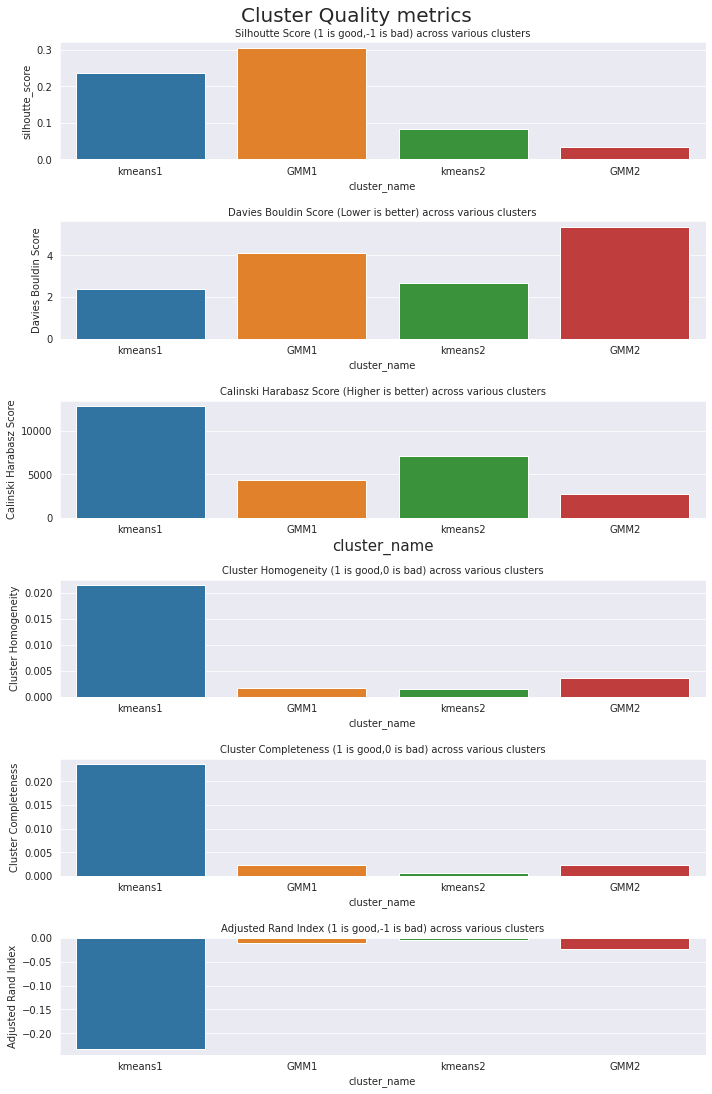

CPU times: user 1.43 s, sys: 206 ms, total: 1.64 s
Wall time: 1.43 s


In [ ]:
%%time

fig, (ax1, ax2,ax3,ax4,ax5,ax6)= plt.subplots(6, 1,figsize=(10,15))

fig.suptitle('Cluster Quality metrics',fontsize=20,x=0.5,y=1.01)


sns.barplot(data=df_silhoutte, x='cluster_name', y='metric_value',ax=ax1)
ax1.set_xticklabels(df_silhoutte['cluster_name'], rotation=0)
ax1.set_xlabel('cluster_name',fontsize=10)
ax1.set_ylabel('silhoutte_score',fontsize=10)
ax1.set_title('Silhoutte Score (1 is good,-1 is bad) across various clusters',fontsize=10)

sns.barplot(data=df_db, x='cluster_name', y='metric_value',ax=ax2)
ax2.set_xticklabels(df_db['cluster_name'], rotation=0)
ax2.set_xlabel('cluster_name',fontsize=10)
ax2.set_ylabel('Davies Bouldin Score',fontsize=10)
ax2.set_title('Davies Bouldin Score (Lower is better) across various clusters',fontsize=10)

sns.barplot(data=df_ch, x='cluster_name', y='metric_value',ax=ax3)
ax3.set_xticklabels(df_ch['cluster_name'], rotation=0)
ax3.set_xlabel('cluster_name',fontsize=15)
ax3.set_ylabel('Calinski Harabasz Score',fontsize=10)
ax3.set_title('Calinski Harabasz Score (Higher is better) across various clusters',fontsize=10)

sns.barplot(data=df_clus_homgn, x='cluster_name', y='metric_value',ax=ax4)
ax4.set_xticklabels(df_clus_homgn['cluster_name'], rotation=0)
ax4.set_xlabel('cluster_name',fontsize=10)
ax4.set_ylabel('Cluster Homogeneity',fontsize=10)
ax4.set_title('Cluster Homogeneity (1 is good,0 is bad) across various clusters',fontsize=10)

sns.barplot(data=df_cluster_com, x='cluster_name', y='metric_value',ax=ax5)
ax5.set_xticklabels(df_cluster_com['cluster_name'], rotation=0)
ax5.set_xlabel('cluster_name',fontsize=10)
ax5.set_ylabel('Cluster Completeness',fontsize=10)
ax5.set_title('Cluster Completeness (1 is good,0 is bad) across various clusters',fontsize=10)

sns.barplot(data=df_ari, x='cluster_name', y='metric_value',ax=ax6)
ax6.set_xticklabels(df_ari['cluster_name'], rotation=0)
ax6.set_xlabel('cluster_name',fontsize=10)
ax6.set_ylabel('Adjusted Rand Index',fontsize=10)
ax6.set_title('Adjusted Rand Index (1 is good,-1 is bad) across various clusters',fontsize=10)

fig.tight_layout()
plt.show()



# 8.Conclusion

From the Cluster evaluation, we find that the clusters generated using kmeans 1 perform better than other 3 clustering approaches on 4 out of 6 evaluation metrics (except silhouette score and ARI).

The message here is that the data may actually have 2 true clusters 



# 9.Saving selected objects as pickle

In [ ]:
# # save to pickle object
pkl_dict={'word_pos_tag_count_X_train_reduced':word_pos_tag_count_X_train_reduced,
          'w2v_X_train_reduced':w2v_X_train_reduced,
          'combined_w2v_X_train_reduced':combined_w2v_X_train_reduced,
          'word_vector_X_train_reduced':word_vector_X_train_reduced,
          'tfidf_vector_X_train_reduced':tfidf_vector_X_train_reduced,


          'word_pos_tag_count_X_dev_reduced':word_pos_tag_count_X_dev_reduced,
          'w2v_X_dev_reduced':w2v_X_dev_reduced,
          'combined_w2v_X_dev_reduced':combined_w2v_X_dev_reduced,
          'word_vector_X_dev_reduced':word_vector_X_dev_reduced,
          'tfidf_vector_X_dev_reduced':tfidf_vector_X_dev_reduced,


          'word_pos_tag_count_X_test_reduced':word_pos_tag_count_X_test_reduced,
          'w2v_X_test_reduced':w2v_X_test_reduced,
          'combined_w2v_X_test_reduced':combined_w2v_X_test_reduced,
          'word_vector_X_test_reduced':word_vector_X_test_reduced,
          'tfidf_vector_X_test_reduced':tfidf_vector_X_test_reduced,








          'kmeans1.labels_':kmeans1.labels_,
          'kmeans2.labels_':kmeans2.labels_,
          'clusters_GMM1':clusters_GMM1,
          'clusters_GMM2':clusters_GMM2,

          'kmeans1':kmeans1,
          'kmeans2':kmeans2,
          'GMM1':GMM1,
          'GMM2':GMM2,

          'kmeans1_dev':kmeans1_dev,
          'kmeans1_test':kmeans1_test,
          'kmeans2_dev':kmeans2_dev,
          'kmeans2_test':kmeans2_test,

          'GMM1_dev':GMM1_dev,
          'GMM1_test':GMM1_test,
          'GMM2_dev':GMM2_dev,
          'GMM2_test':GMM2_test,

          'GMM1_probs':GMM1_probs,
          'GMM2_probs':GMM2_probs,

          
          
          }

pickle_out = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/pkl_dict_unsupvd.pickle","wb")
pickle.dump(pkl_dict, pickle_out)
pickle_out.close()

# 10.Dependencies

In [ ]:
# Dependencies
# providing watermark
# !pip install watermark
%reload_ext watermark
%watermark
%watermark --iversions

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
matplotlib : 3.2.2
seaborn    : 0.11.2
sklearn    : 0.0
gzip       : unknown
json       : 2.0.9
re         : 2.2.1
random     : unknown
collections: unknown
tqdm       : 4.62.2
zipfile    : unknown
os         : unknown
pickle_out : not installed
dask-ml    : not installed
delayed    : 0.11.0b1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

